# 0. Imports & inputs

In [4]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.analytic_solar_cells.diode_equation import iv_2diode
from solcore.analytic_solar_cells.IV import iv_multijunction
from solcore.solar_cell_solver import default_options, solar_cell_solver
import pprint
import os
from datetime import datetime
import scipy.constants as const
import pvlib
from scipy.constants import Boltzmann, e

# define the plot template
axis_label_size = 20
axis_num_size = 20
text_size = 20
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)
two_by_two_figsize = (12, 12)

# define the random seed for reproducibility
np.random.seed(666)

# define the number of IV curves to simulate and validate
num_curves = 50
# define the module area
module_area = 2 # m2
# define the number of cells in series and parallel
num_s_cells = 72
num_p_cells = 2

# define the range of Rs, Rsh, J01 J02, IL, T for the simulation
Rsmin = 0.1  # Ohm, from the modules I have
Rshmin = 200  # Ohm, from the modules I have
Rsmax = 0.4  # Ohm, from the modules I have
Rshmax = 1200  # Ohm, from the modules I have
J01min = 1e-14  # A/m2, from PV education range
J01max = 1e-8  # A/m2, from PV education range
J02min = 1e-12  # A/m2, from PV education range
J02max = 1e-6  # A/m2, from PV education range
ILmin = 8  # A/m2, from the modules I have
ILmax = 15  # A/m2, from the modules I have
Tmin = 273  # K, from the modules I have
Tmax = 343  # K, from the modules I have
N_param = 1000 # parameter sample size

# define the temprautre coeffiicnet of Rs
alpha_Rs = 0.356 # %/K

# print out the default options
print("Default options:")
# Pretty‑print the entire defaults dict:
pprint.pprint(default_options)

# define the folder to save data
save_folder = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\2_diode_models\dummy_module"

# define the function to calculate the I0 at MPPT
def calc_I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def calc_IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL

Default options:
State([('T_ambient', 298),
       ('T', 298),
       ('wavelength',
        array([3.000e-07, 3.060e-07, 3.120e-07, 3.180e-07, 3.240e-07, 3.300e-07,
       3.360e-07, 3.420e-07, 3.480e-07, 3.540e-07, 3.600e-07, 3.660e-07,
       3.720e-07, 3.780e-07, 3.840e-07, 3.900e-07, 3.960e-07, 4.020e-07,
       4.080e-07, 4.140e-07, 4.200e-07, 4.260e-07, 4.320e-07, 4.380e-07,
       4.440e-07, 4.500e-07, 4.560e-07, 4.620e-07, 4.680e-07, 4.740e-07,
       4.800e-07, 4.860e-07, 4.920e-07, 4.980e-07, 5.040e-07, 5.100e-07,
       5.160e-07, 5.220e-07, 5.280e-07, 5.340e-07, 5.400e-07, 5.460e-07,
       5.520e-07, 5.580e-07, 5.640e-07, 5.700e-07, 5.760e-07, 5.820e-07,
       5.880e-07, 5.940e-07, 6.000e-07, 6.060e-07, 6.120e-07, 6.180e-07,
       6.240e-07, 6.300e-07, 6.360e-07, 6.420e-07, 6.480e-07, 6.540e-07,
       6.600e-07, 6.660e-07, 6.720e-07, 6.780e-07, 6.840e-07, 6.900e-07,
       6.960e-07, 7.020e-07, 7.080e-07, 7.140e-07, 7.200e-07, 7.260e-07,
       7.320e-07, 7.380e-07, 7.

# 1. Parameter simulation

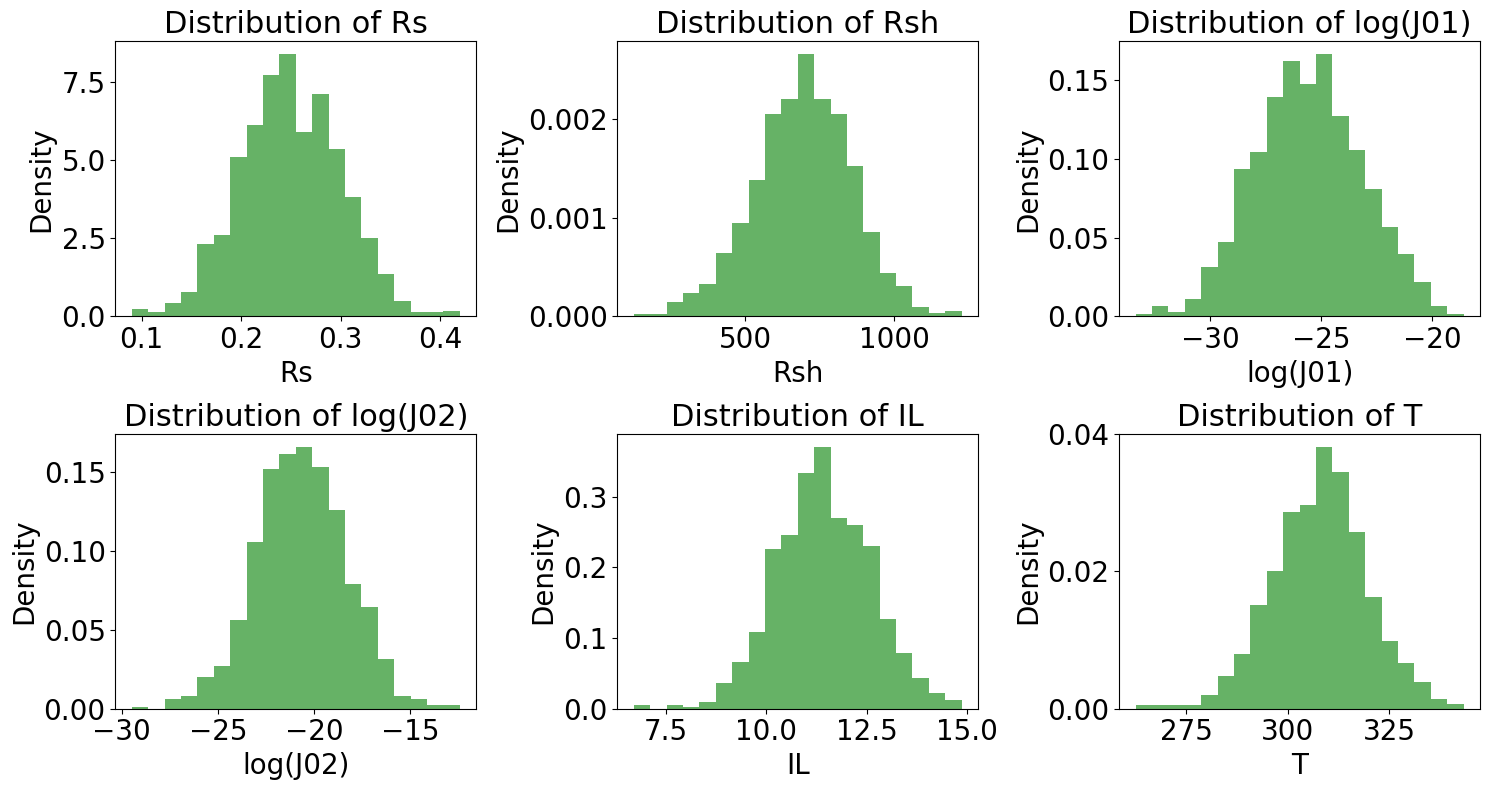

          Rs         Rsh           J01           J02         IL           T
0   0.286867  635.802734  1.349235e-14  7.158937e-08  10.857520  304.416567
1   0.255019  634.170567  2.689987e-12  1.122918e-11  12.870458  298.070471
2   0.219946  639.825138  4.353777e-13  4.706237e-10  13.327781  314.994810
3   0.195725  747.100463  2.660338e-11  2.957682e-10  10.641133  296.373700
4   0.294181  588.198953  3.175197e-11  2.766917e-10  11.572950  334.307603
5   0.170628  662.832740  2.152268e-10  3.956769e-06  11.385004  295.192956
6   0.272349  750.531162  3.631822e-12  7.562911e-09  10.828615  288.589749
7   0.279690  590.695980  5.353688e-11  4.081111e-08  11.351095  313.916396
8   0.213186  882.139309  4.884357e-13  7.041490e-11  10.059057  318.494871
9   0.160035  588.198953  9.401223e-11  3.102796e-09  10.979987  298.519709
10  0.192979  761.377690  1.776603e-10  1.790071e-09   9.632603  315.172270
11  0.290007  826.653568  9.692011e-12  9.598915e-08  11.260517  280.225861
12  0.292232

In [5]:
# Generate your parameter distributions (linear space)
for param in ['Rs', 'Rsh', 'IL', 'T']:
    mean     = (eval(param + 'max') + eval(param + 'min')) / 2
    std      = (eval(param + 'max') - eval(param + 'min')) / 6
    globals()[param + '_values'] = np.random.normal(mean, std, N_param)

# Special handling for J01 and J02: sample log-values (as before)
for param in ['J01', 'J02']:
    log_min   = np.log(eval(param + 'min'))
    log_max   = np.log(eval(param + 'max'))
    mean_log  = (log_max + log_min) / 2
    std_log   = (log_max - log_min) / 6
    log_vals  = np.random.normal(mean_log, std_log, N_param)
    globals()[param + '_values'] = np.exp(log_vals)

# Plotting all six on a 2×3 grid of subplots, 
# but for J01/J02 we plot their natural log
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, param in zip(axes, ['Rs', 'Rsh', 'J01', 'J02', 'IL', 'T']):
    values = globals()[param + '_values']
    if param in ['J01', 'J02']:
        # take natural log for plotting
        values = np.log(values)
        xlabel = f'log({param})'
        title  = f'Distribution of log({param})'
    else:
        xlabel = param
        title  = f'Distribution of {param}'
    
    ax.hist(values,
            bins=20,
            density=True,
            alpha=0.6,
            color='g')
    ax.set_title(title, fontsize=title_size)
    ax.set_xlabel(xlabel, fontsize=axis_label_size)
    ax.set_ylabel('Density', fontsize=axis_label_size)
    ax.tick_params(axis='both', labelsize=axis_num_size)

plt.tight_layout()
plt.show()

# resample num_curves number of times from the distributions, create a DataFrame
# Draw num_curves samples from each _values array
samples = {}
for param in ['Rs', 'Rsh', 'J01', 'J02', 'IL', 'T']:
    samples[param] = np.random.choice(
        globals()[param + '_values'],
        size=num_curves,
        replace=True
    )

# Build DataFrame
df = pd.DataFrame(samples)

# print the head
print(df)


# 2. Two diode model IV curve generation

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


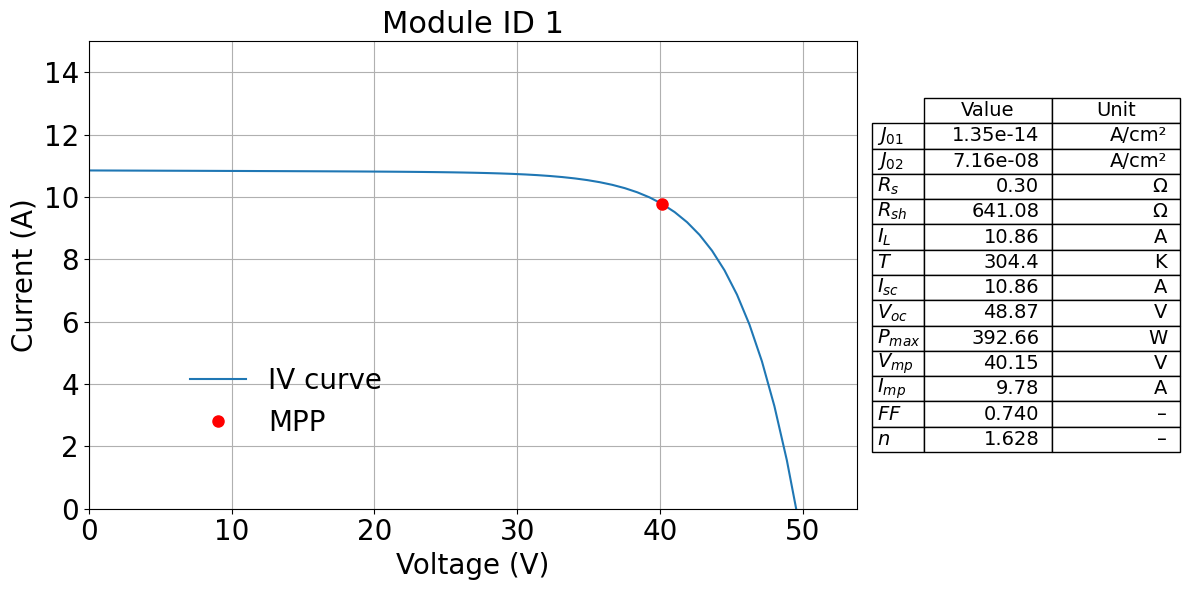

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


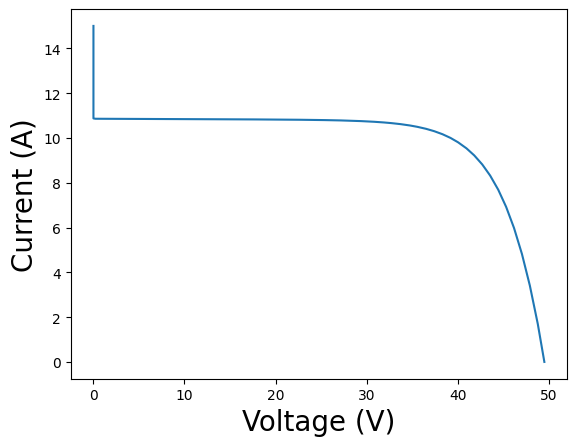

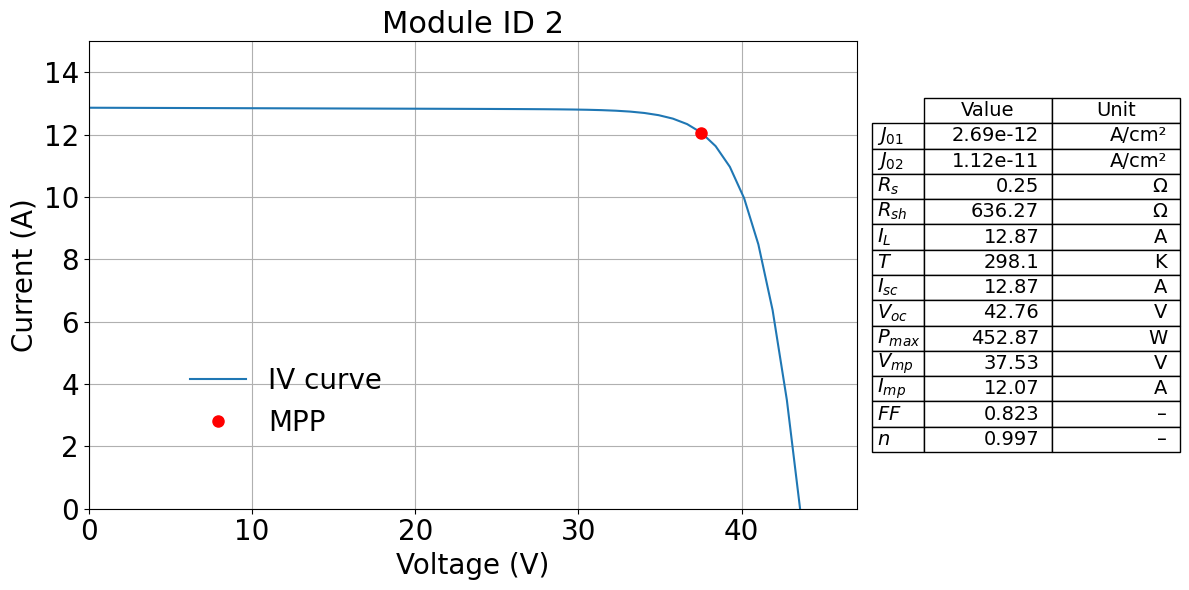

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


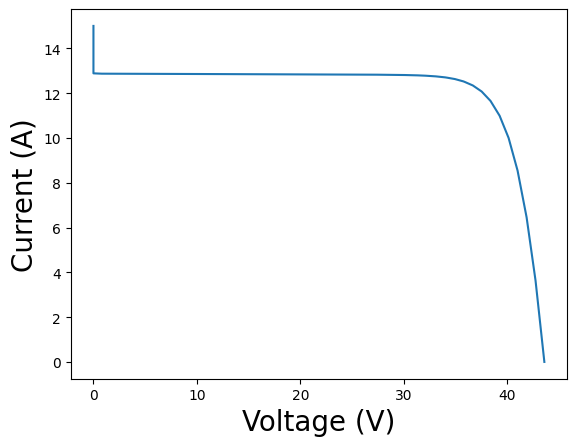

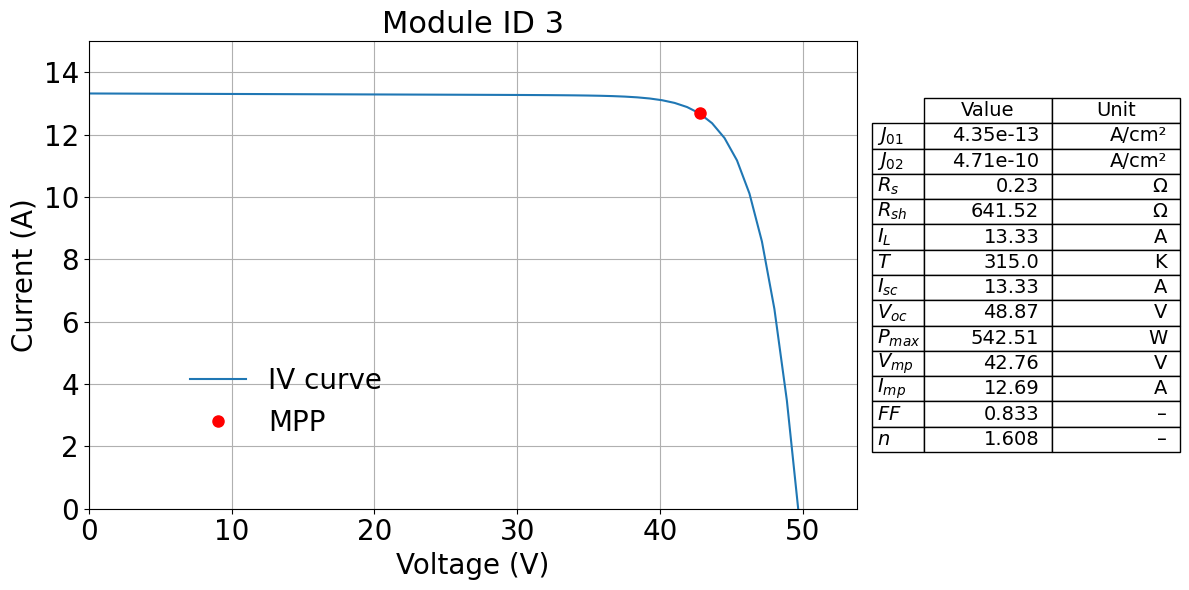

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


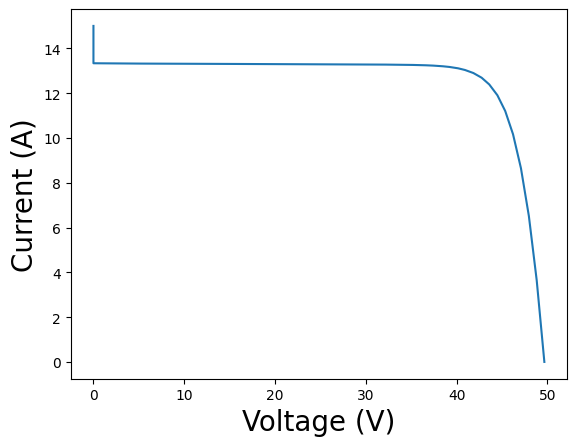

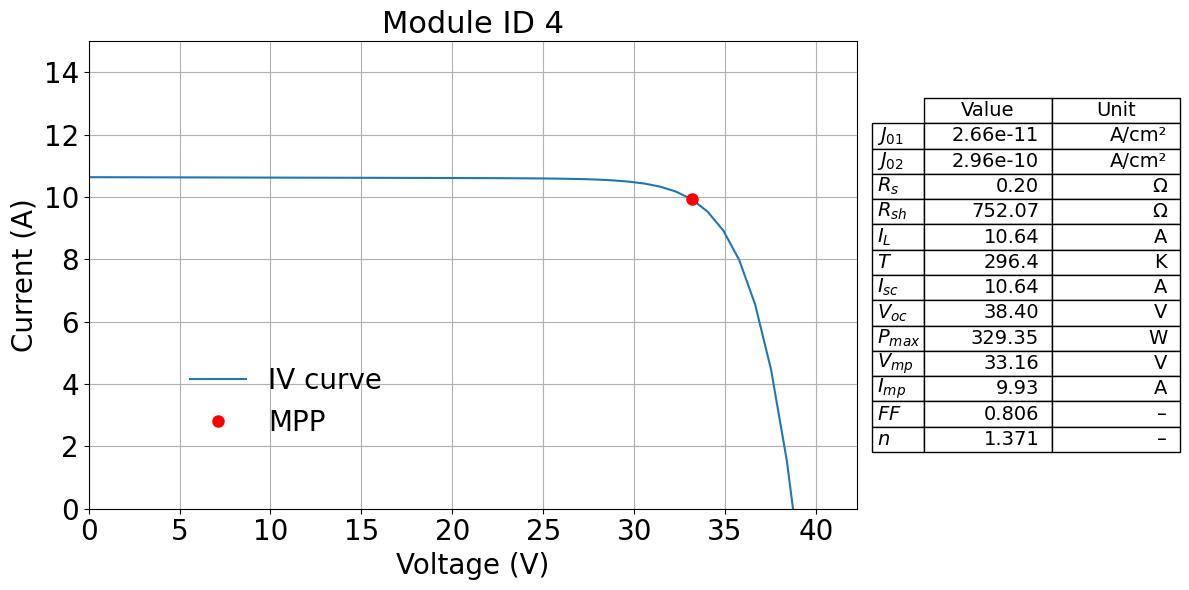

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


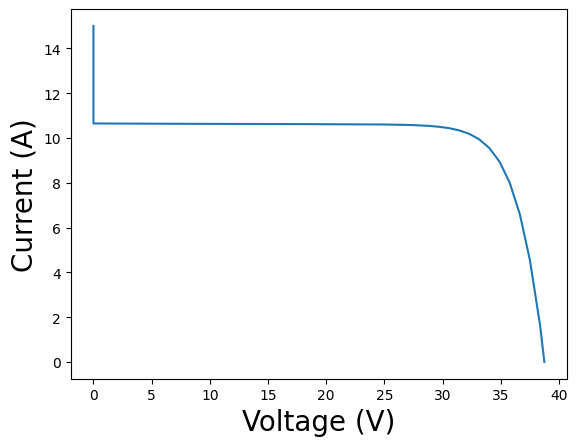

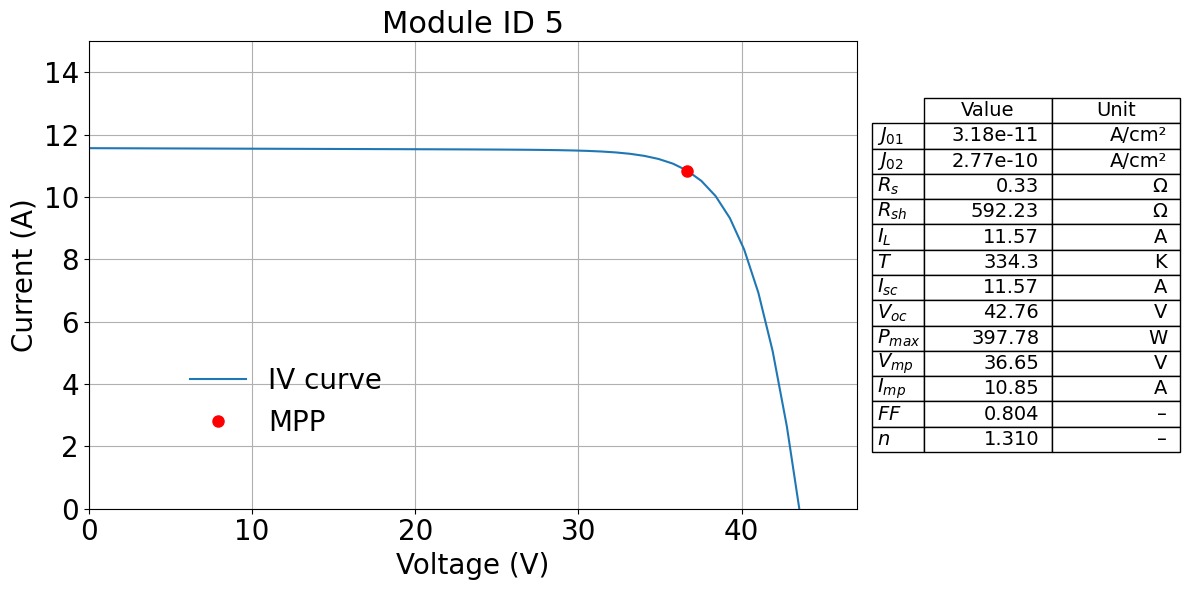

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


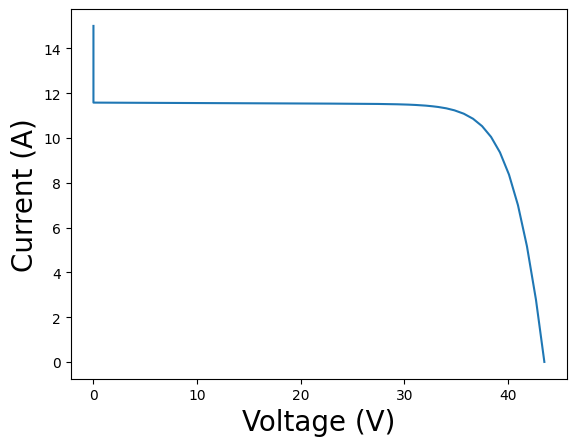

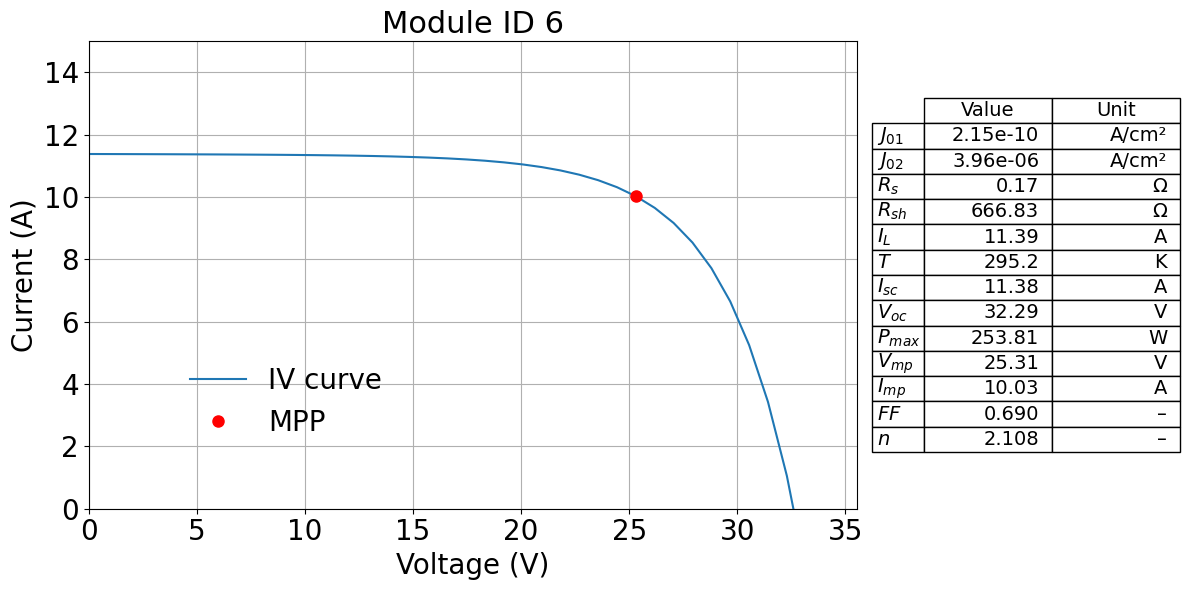

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


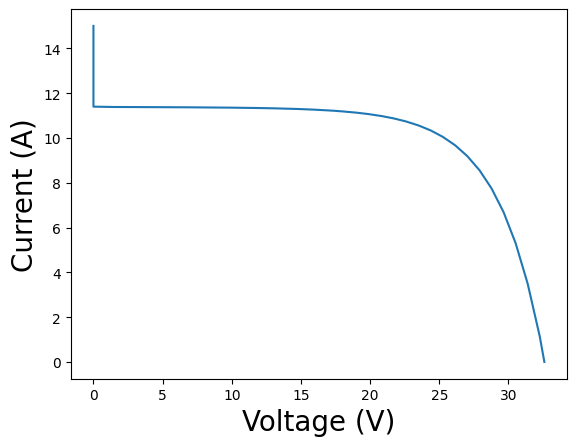

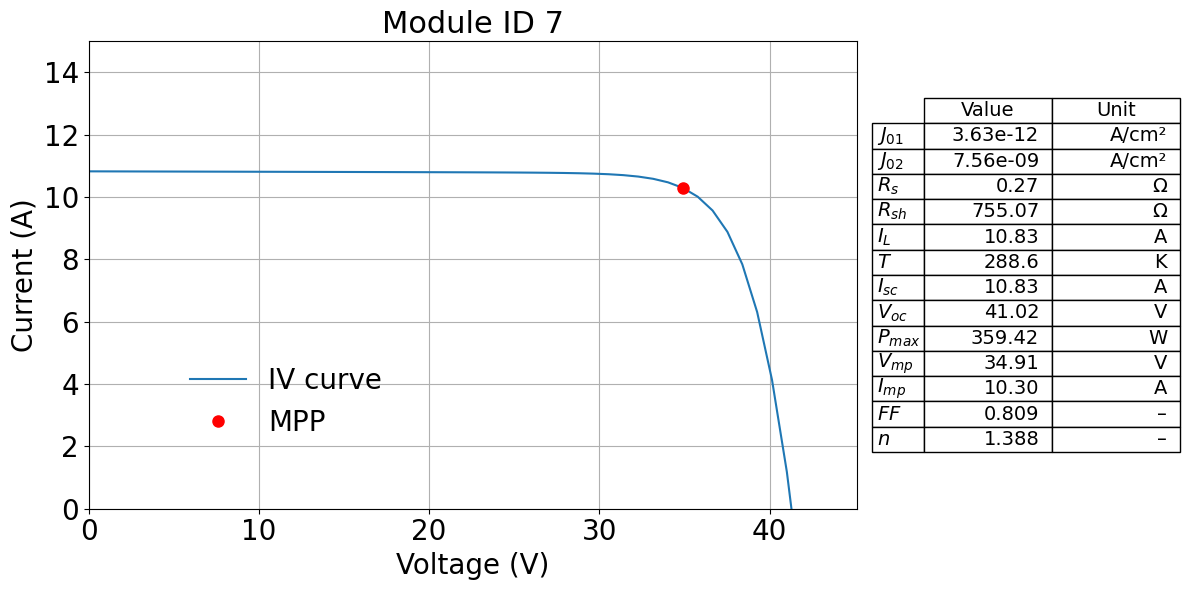

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


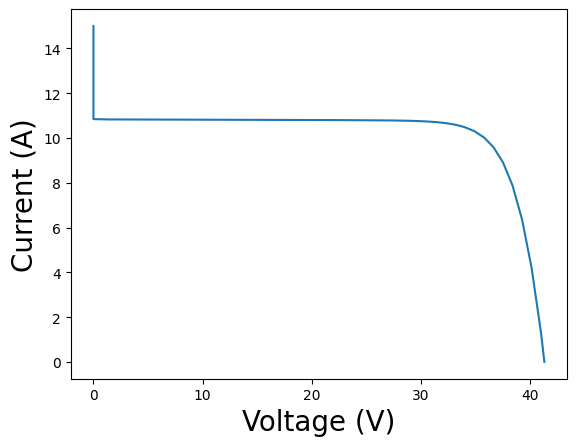

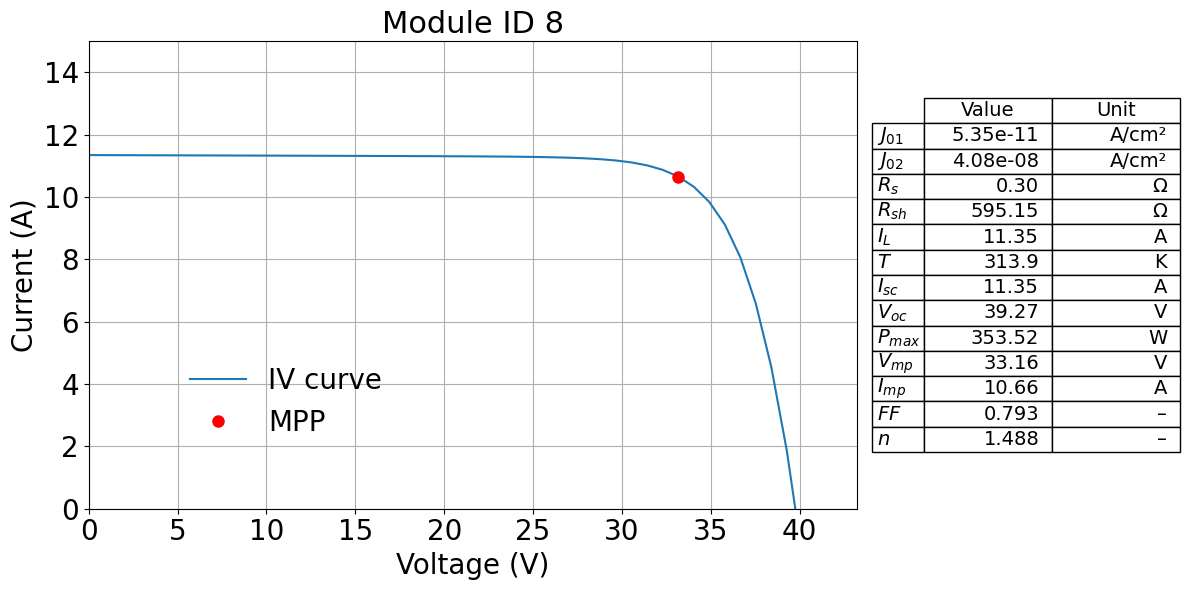

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


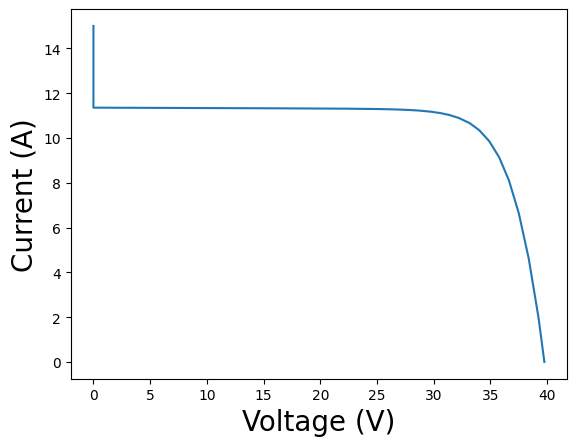

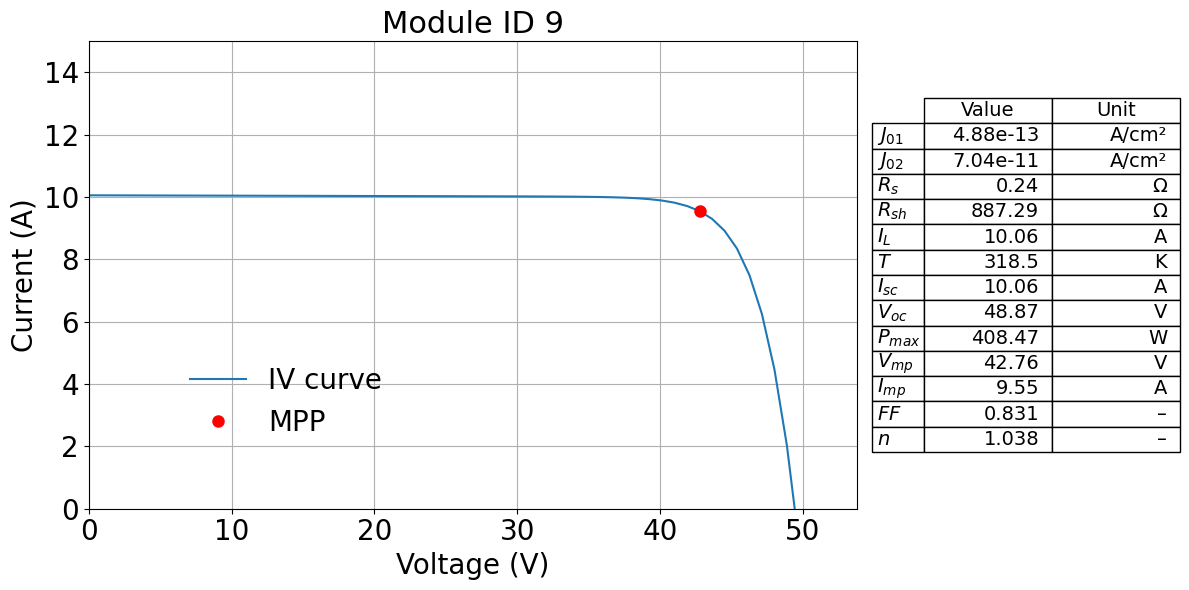

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


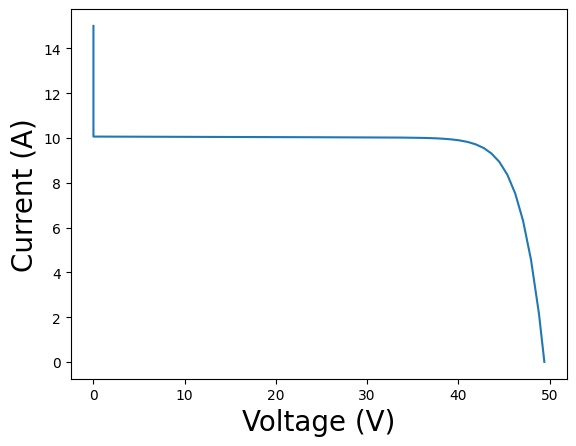

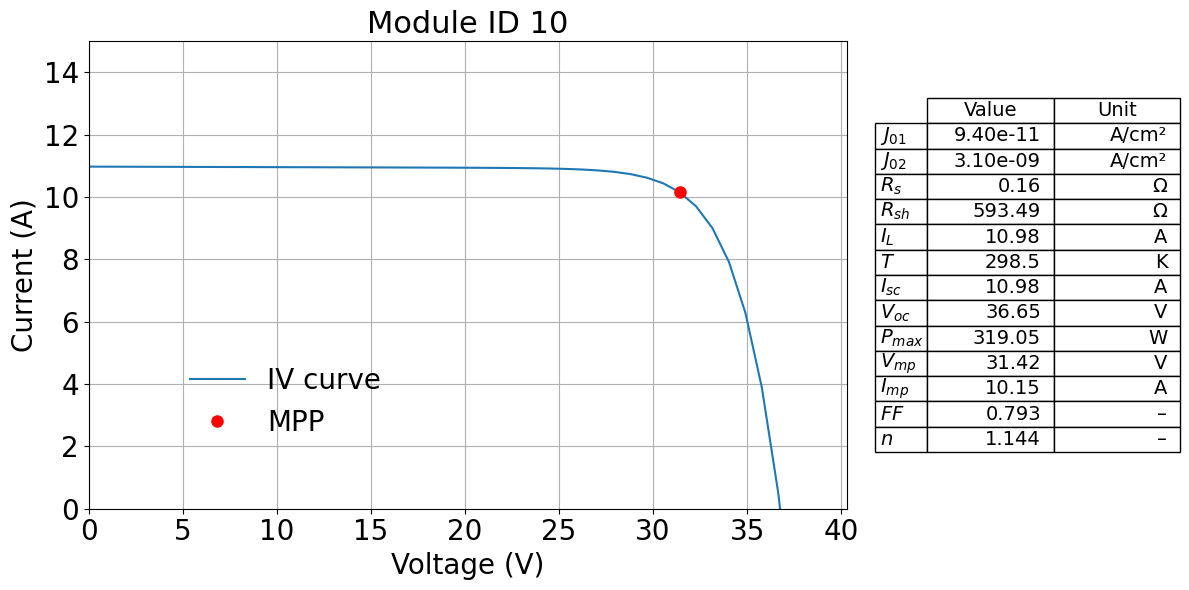

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


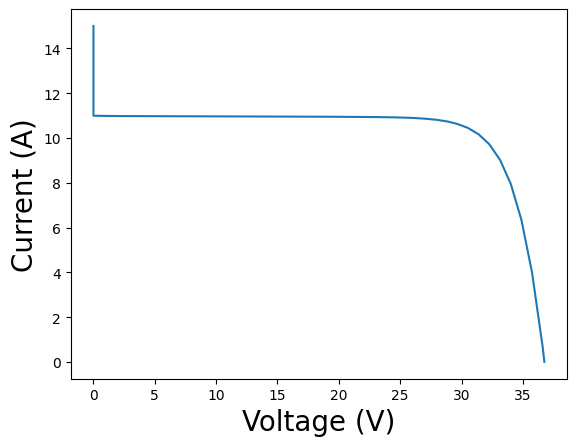

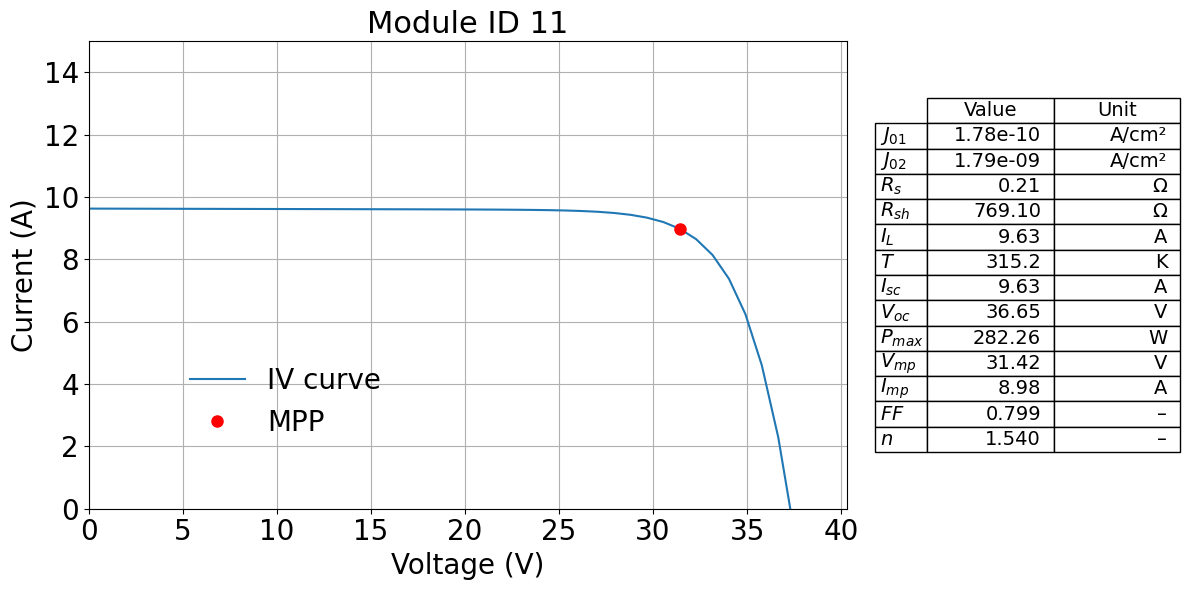

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


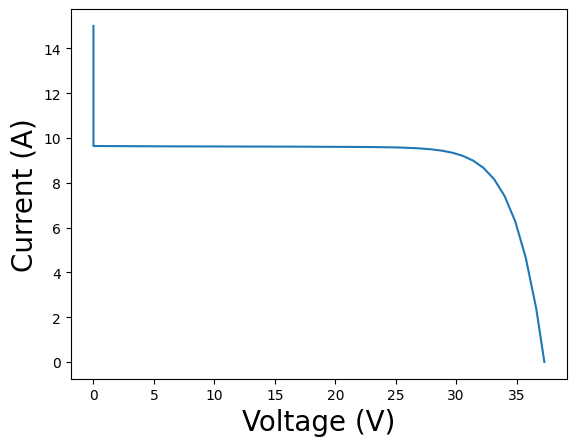

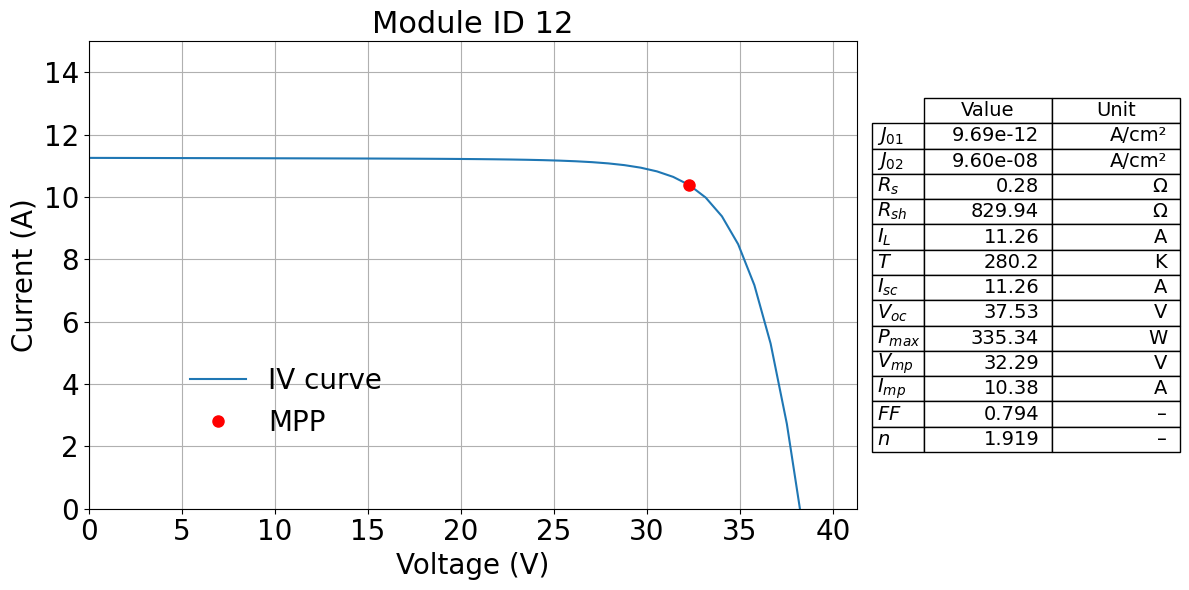

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


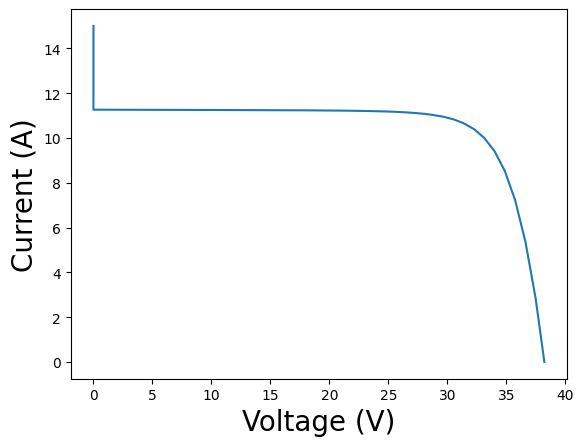

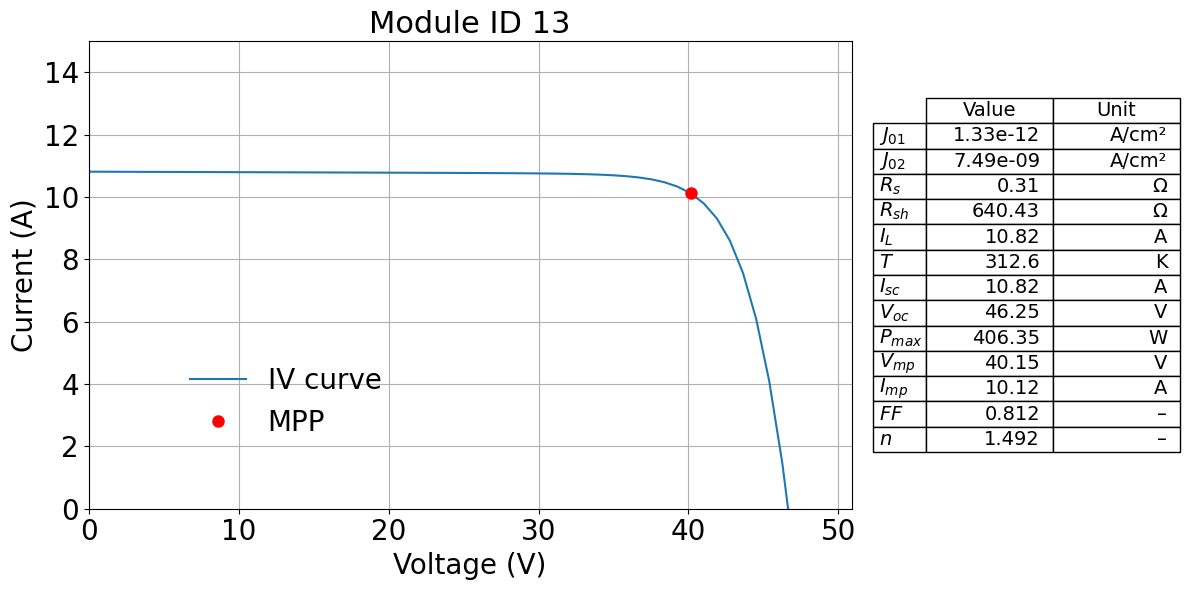

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


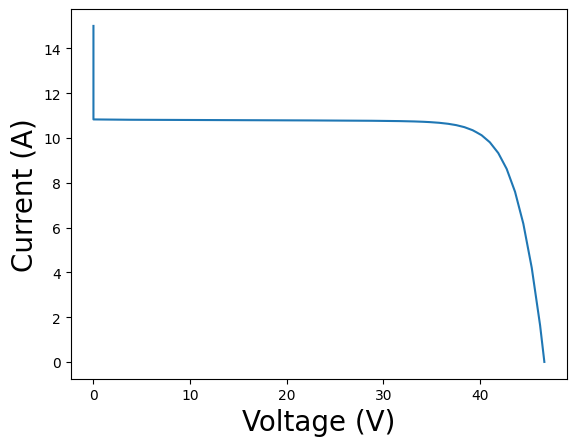

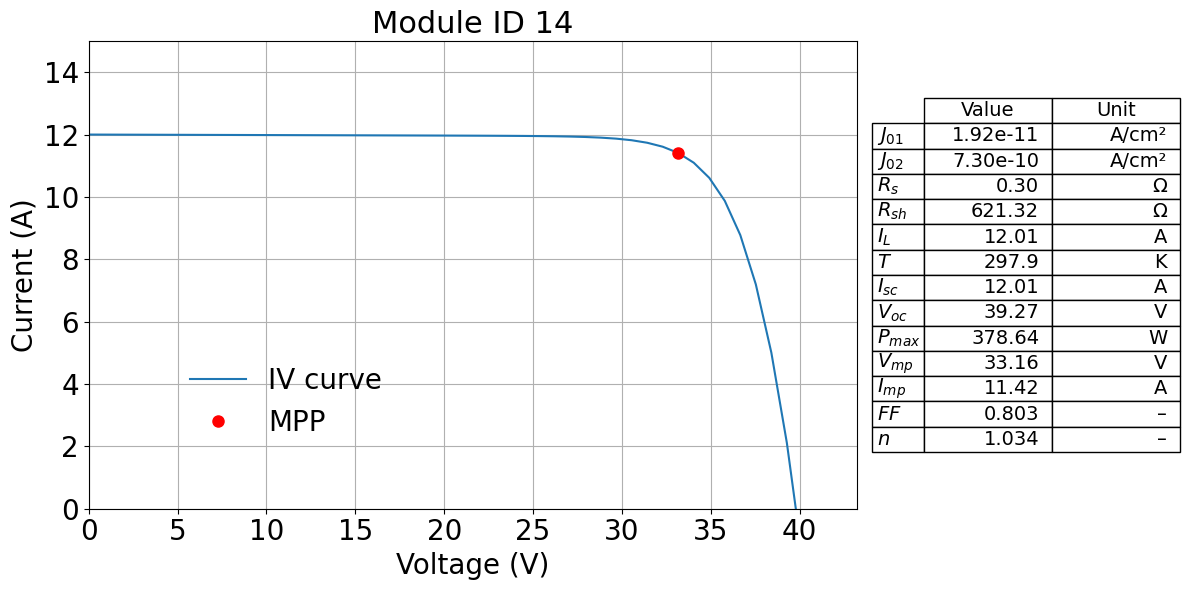

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


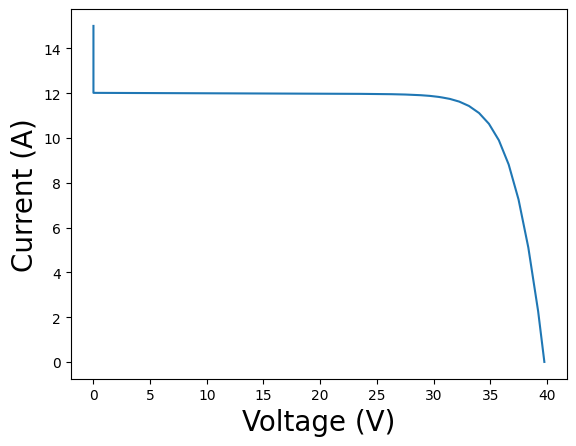

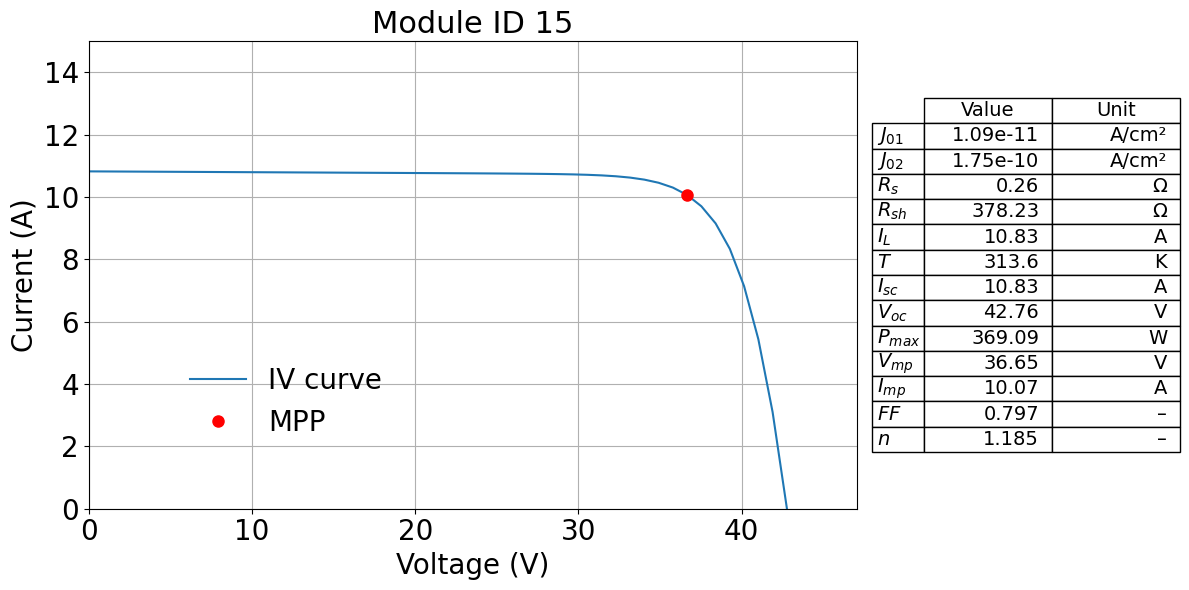

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


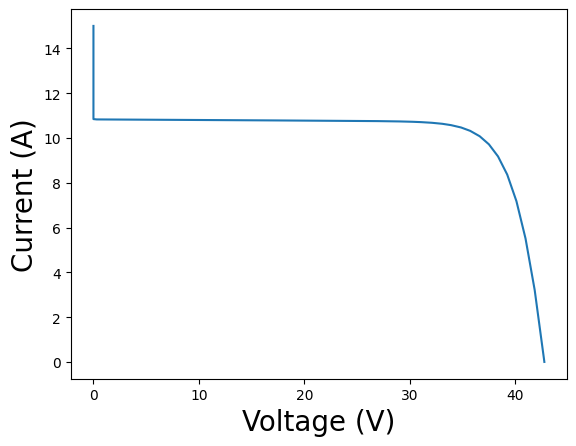

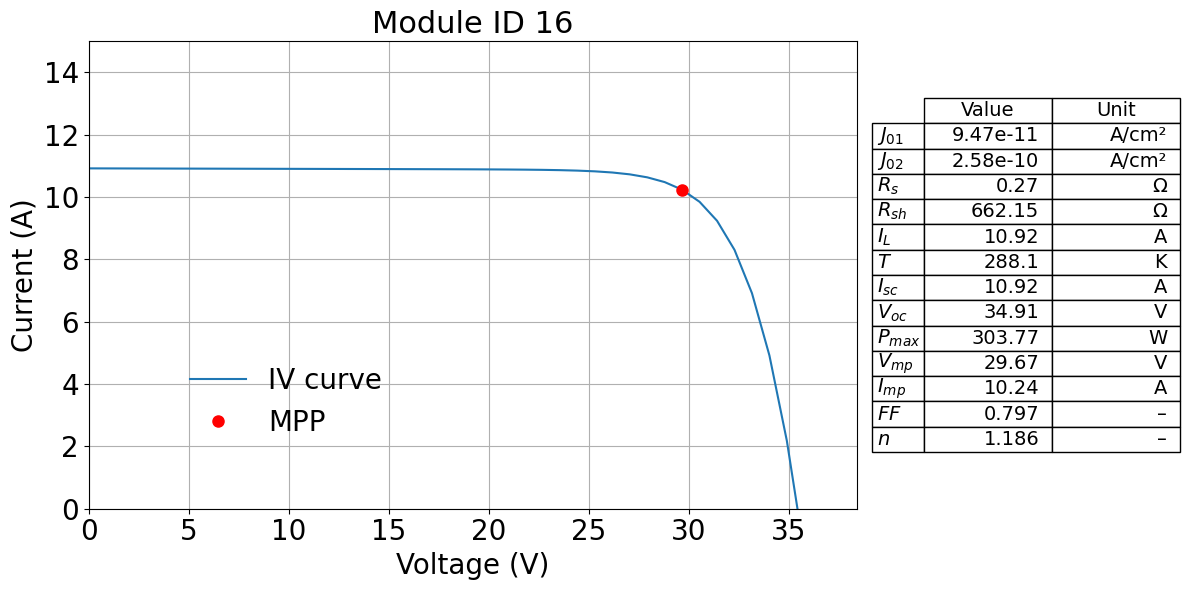

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


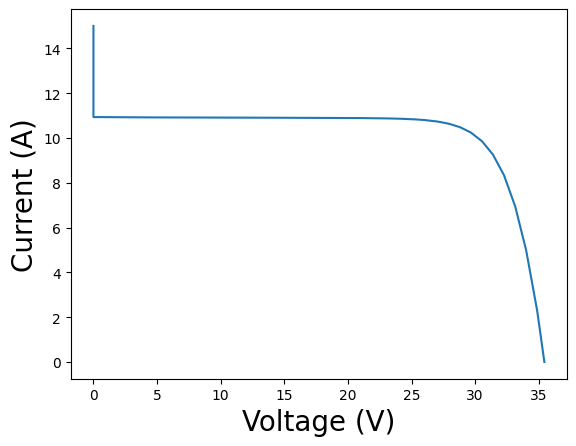

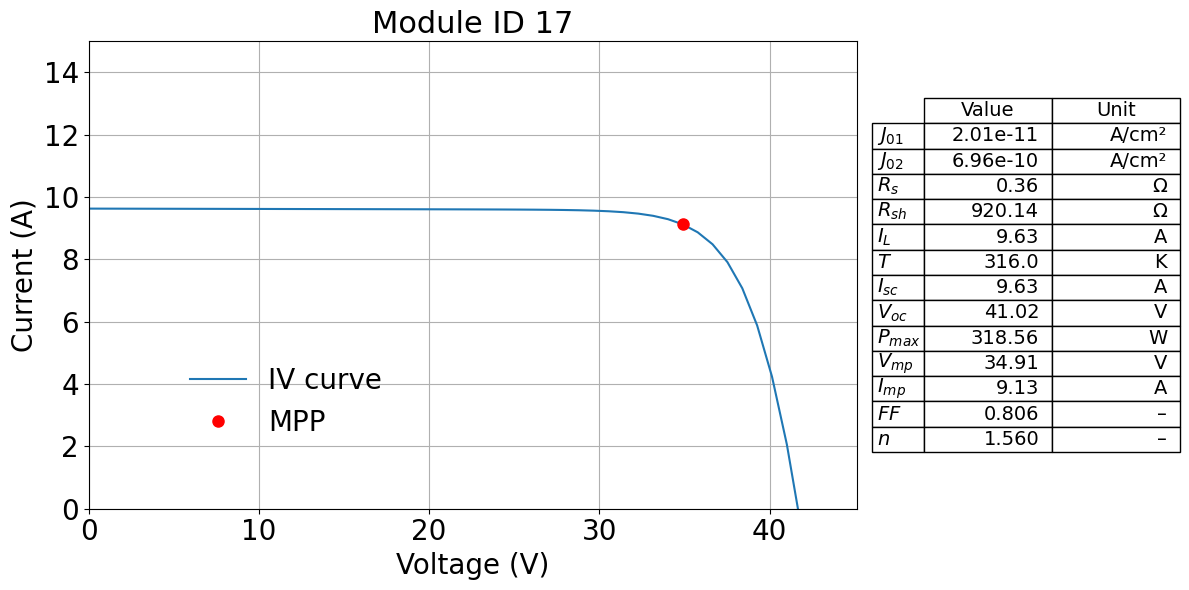

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


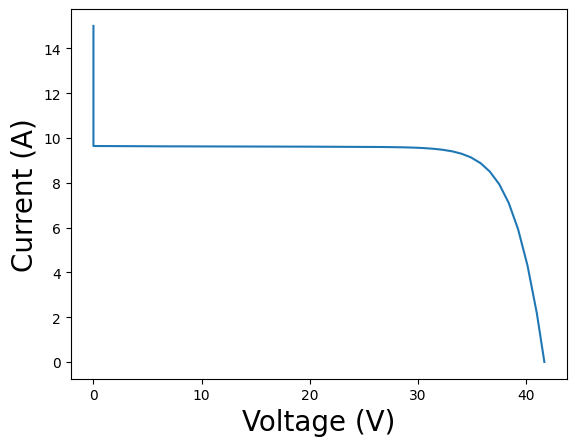

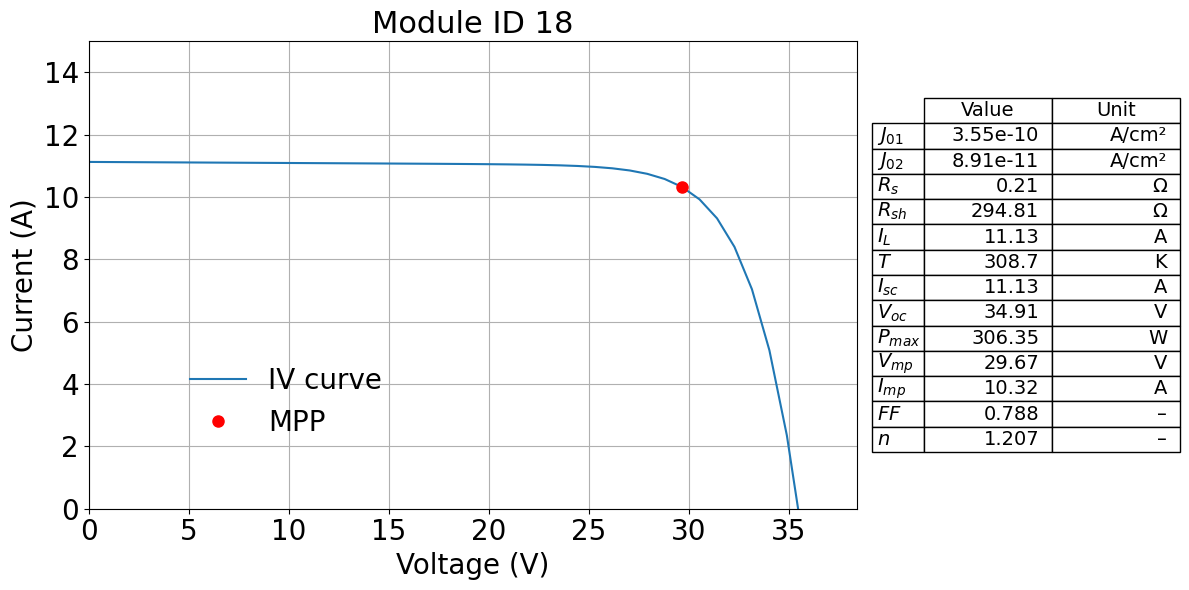

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


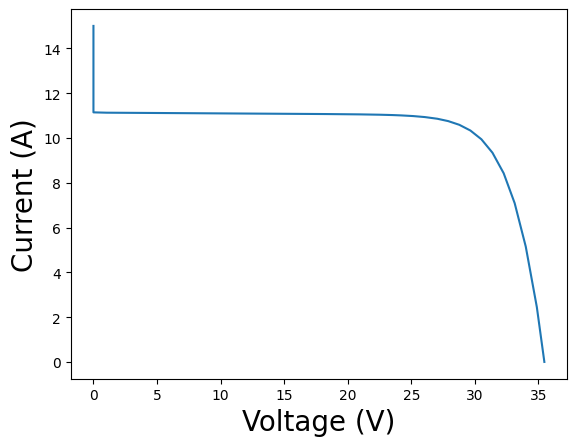

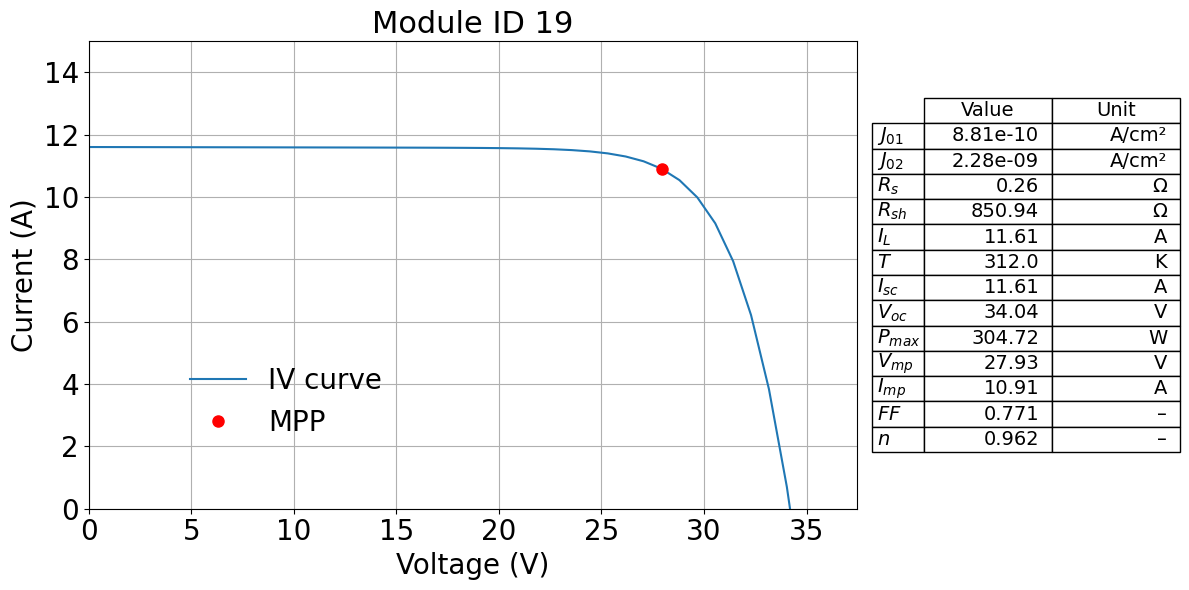

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


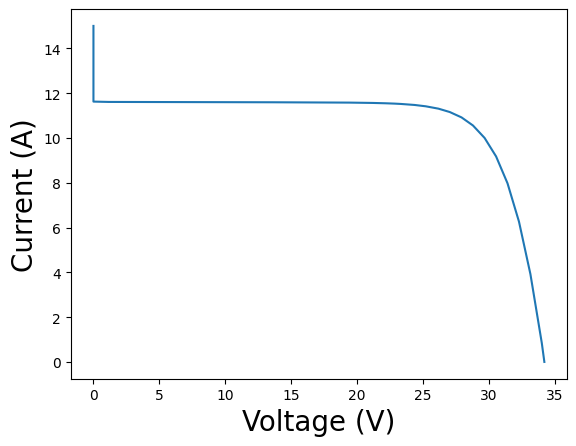

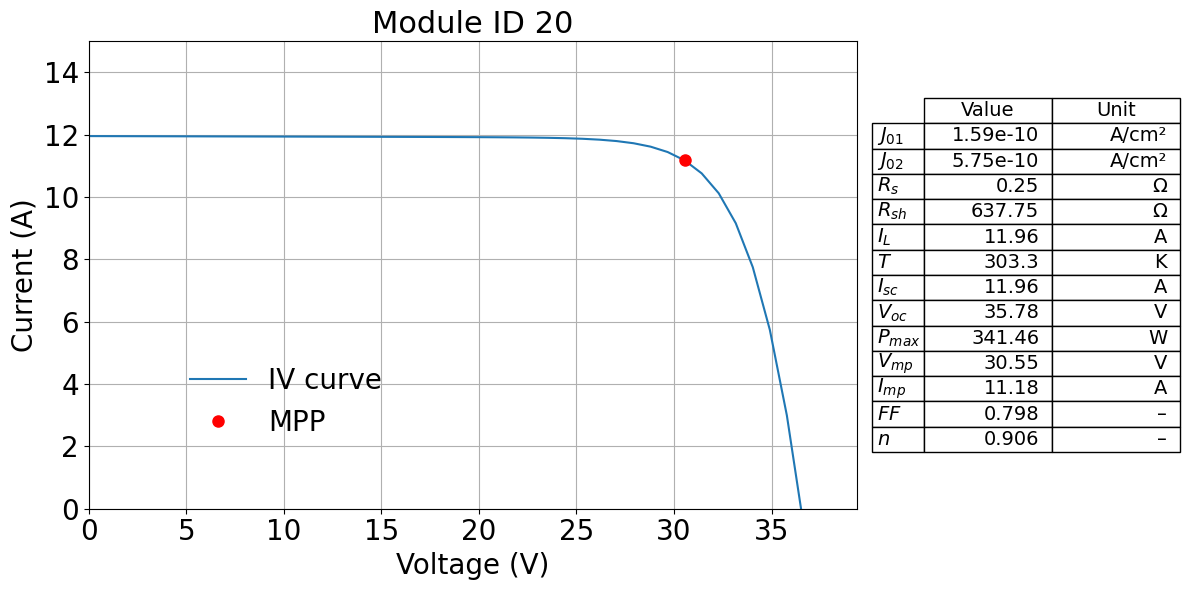

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


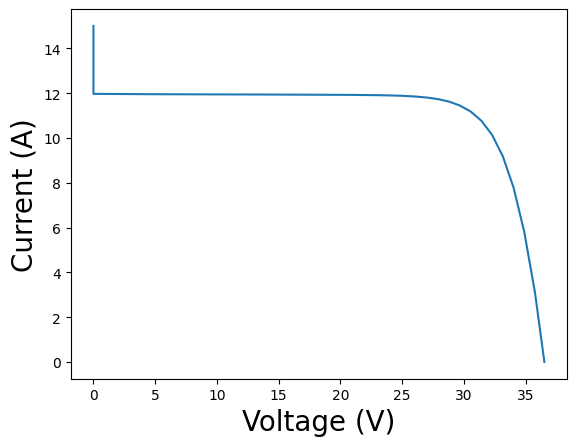

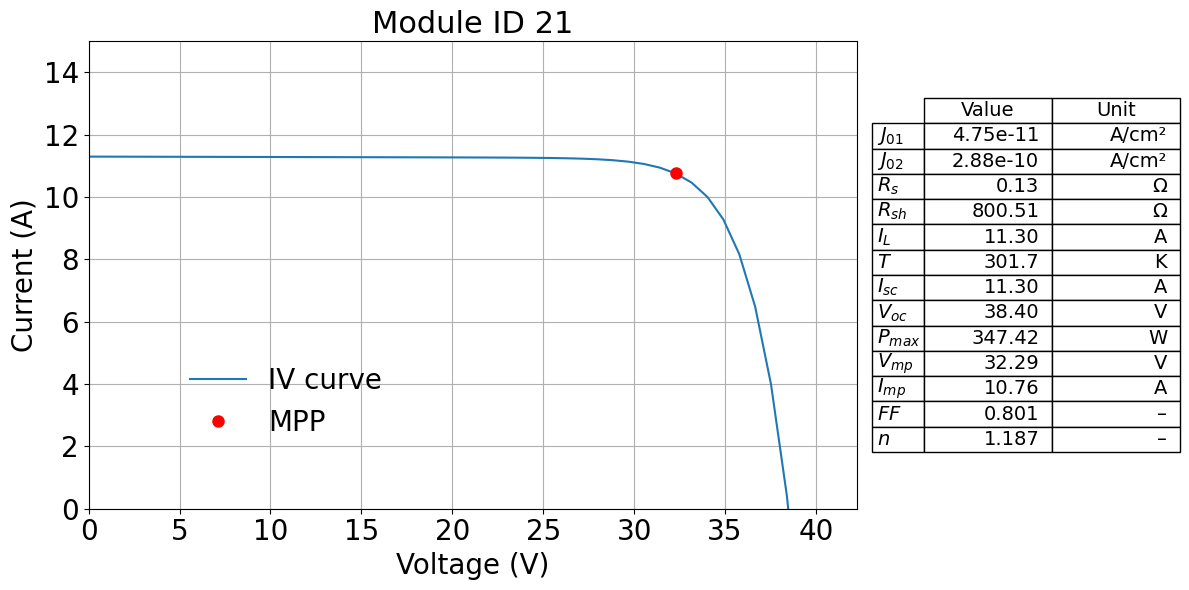

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


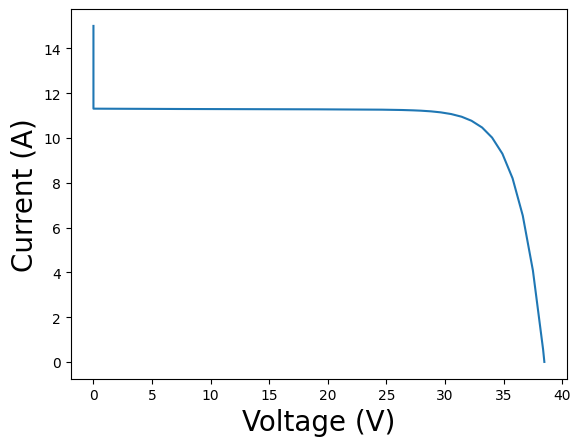

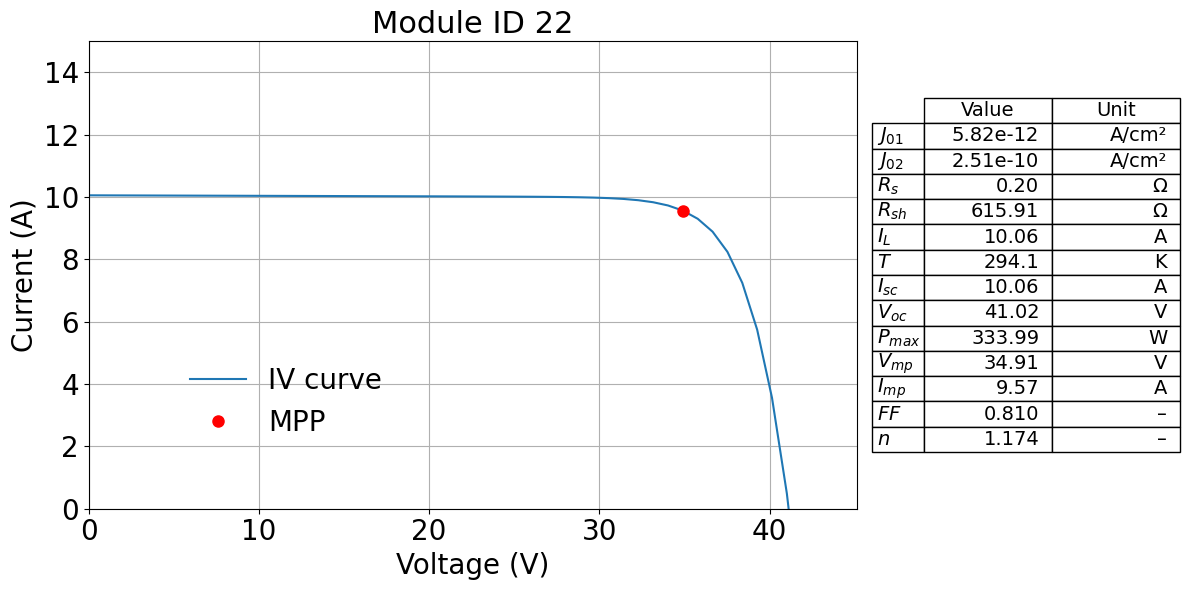

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


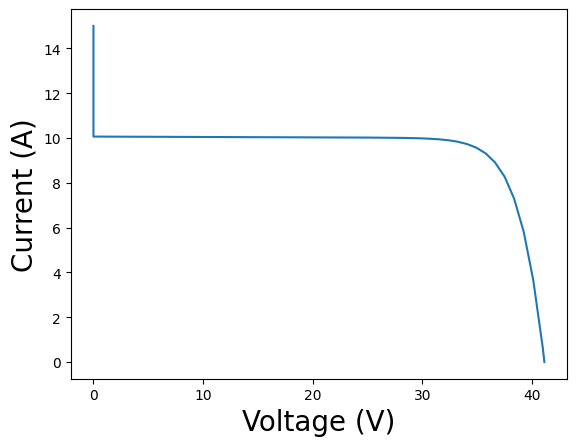

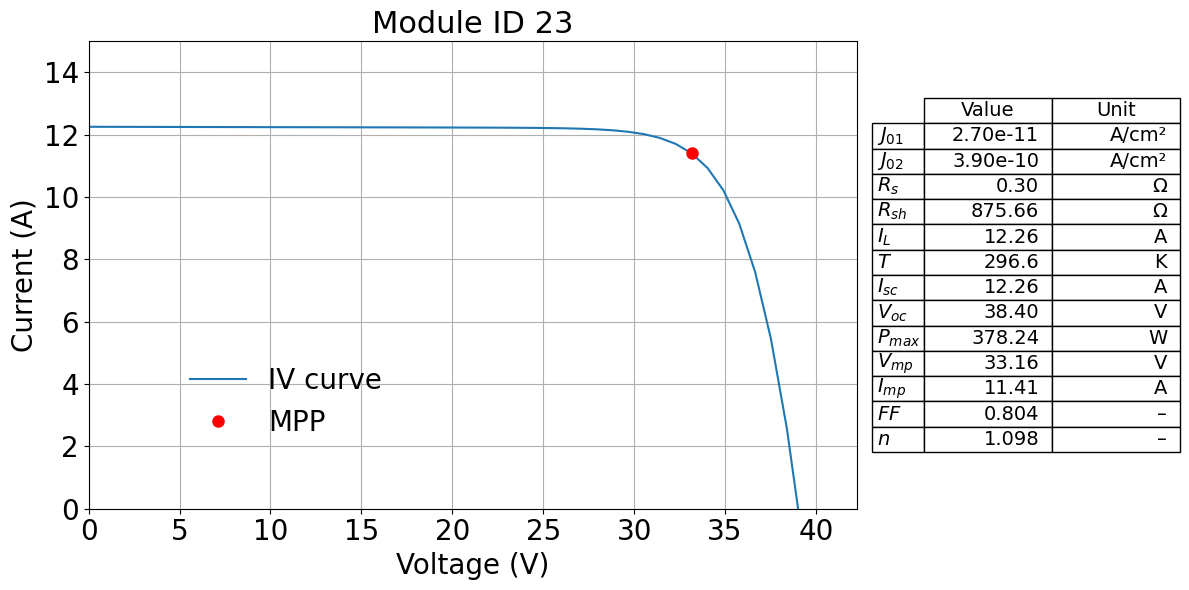

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


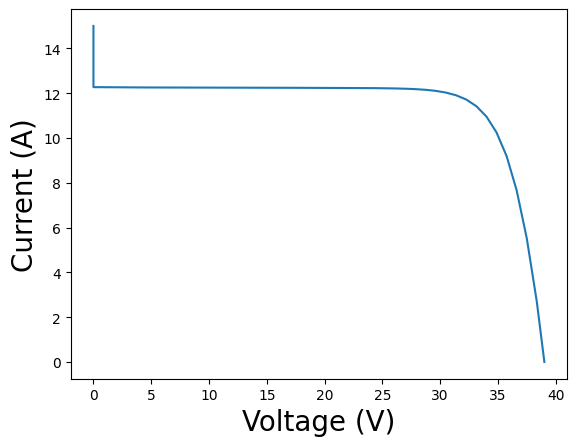

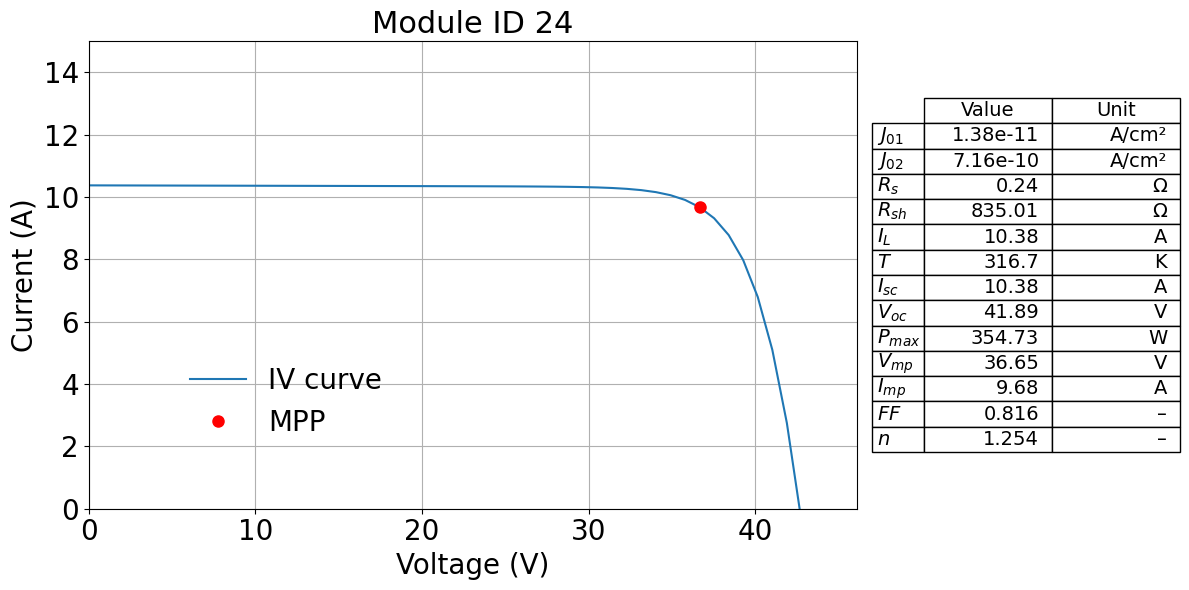

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


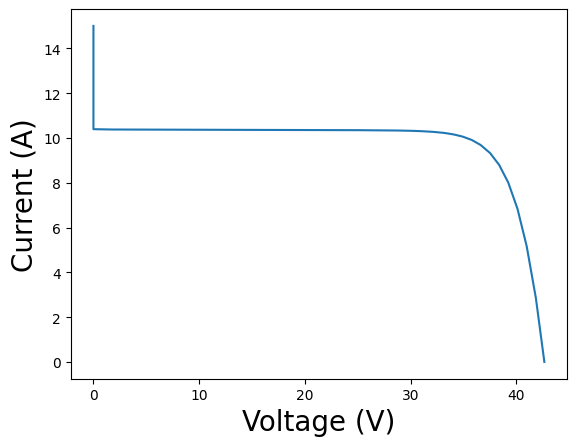

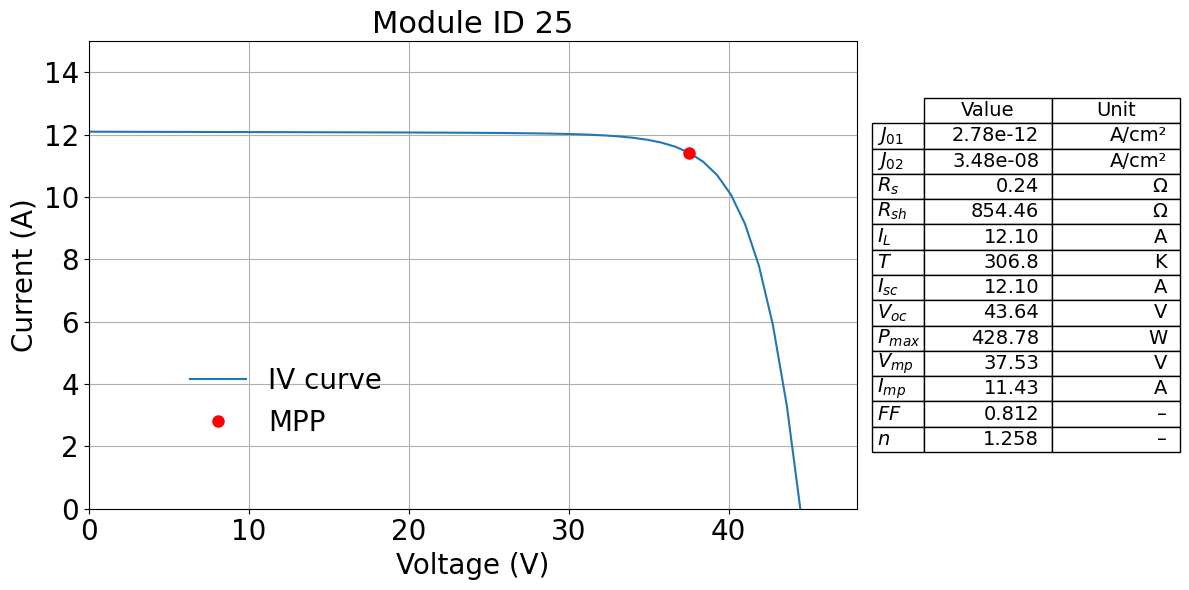

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


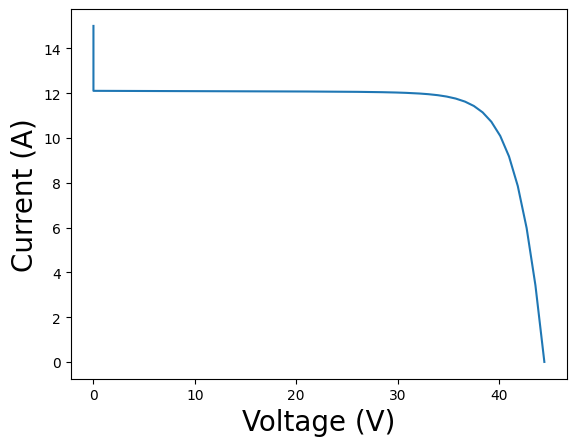

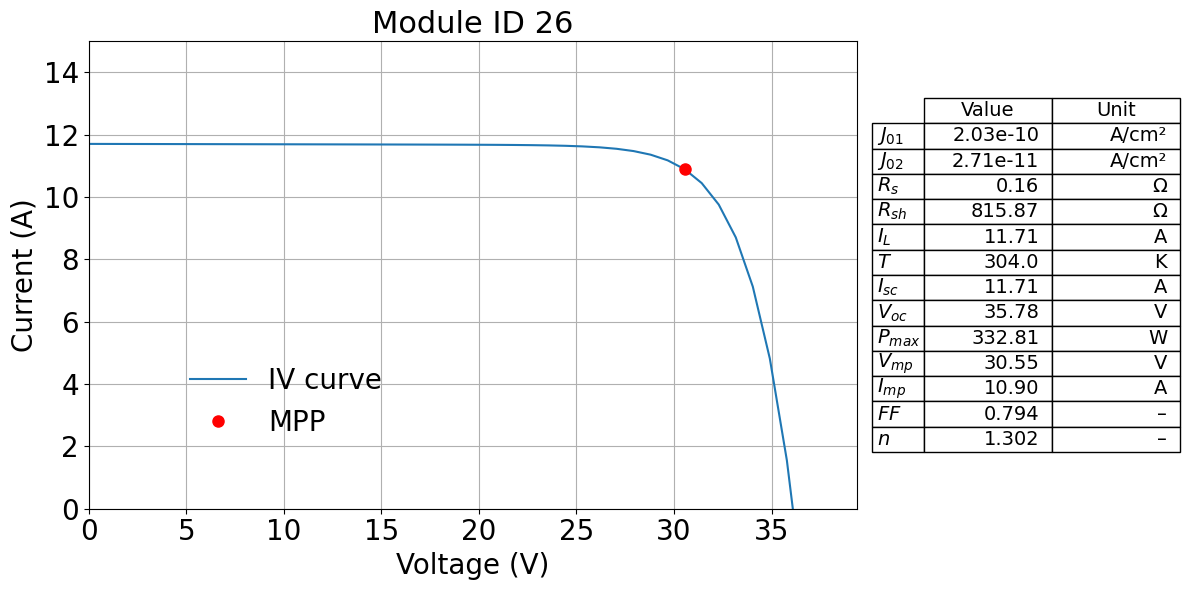

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


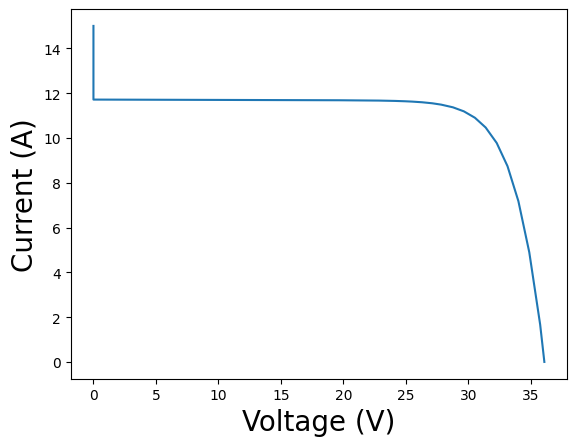

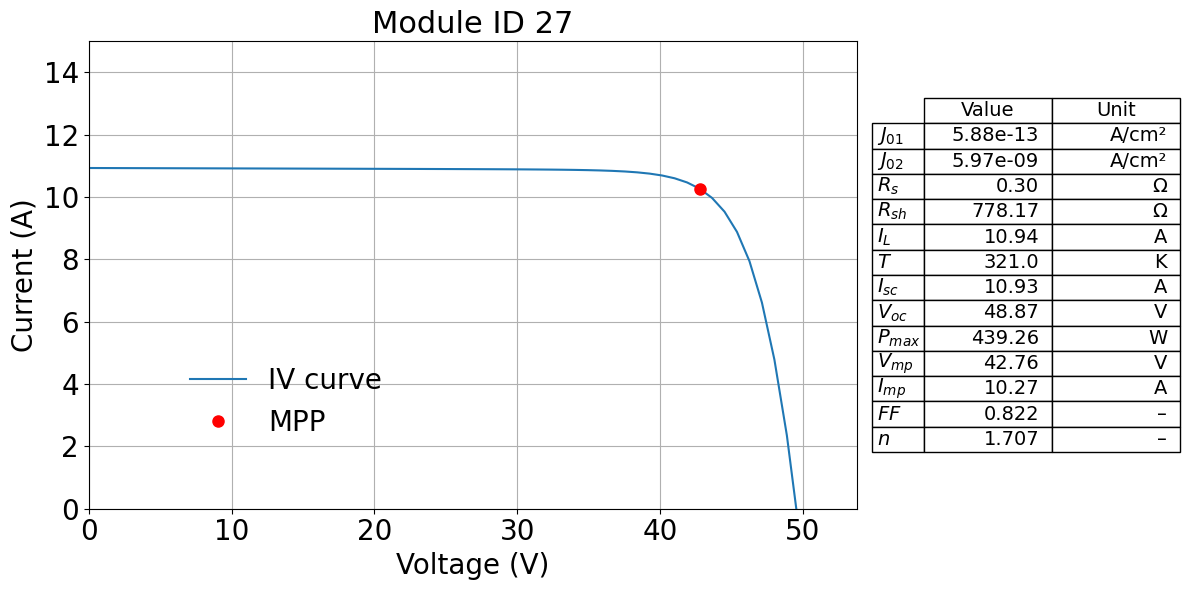

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


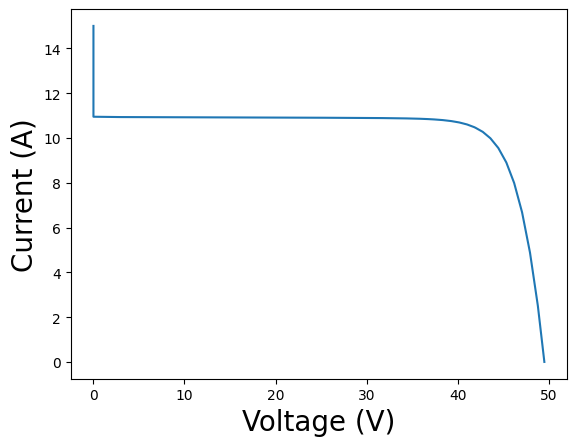

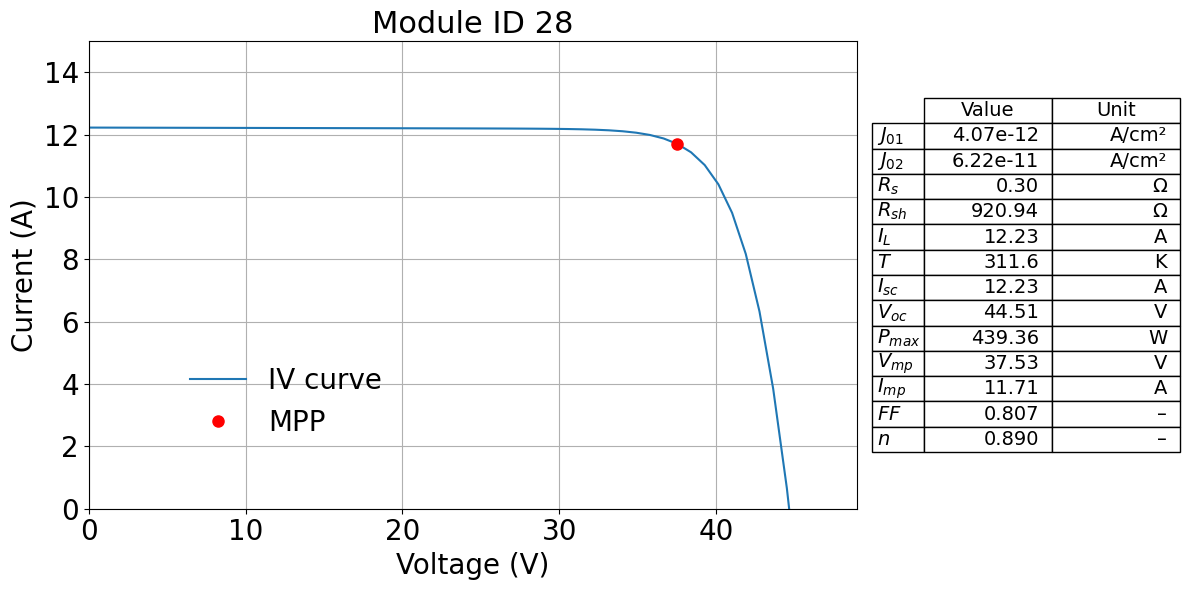

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


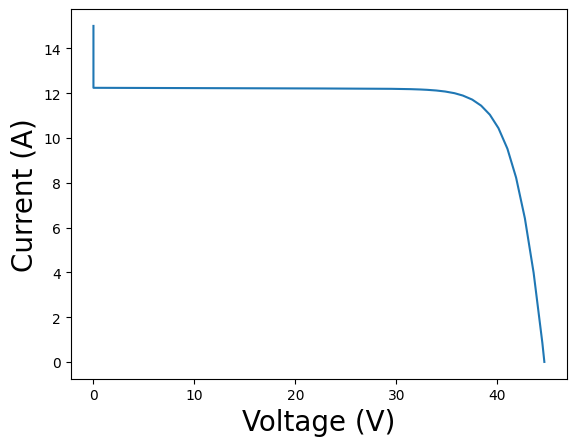

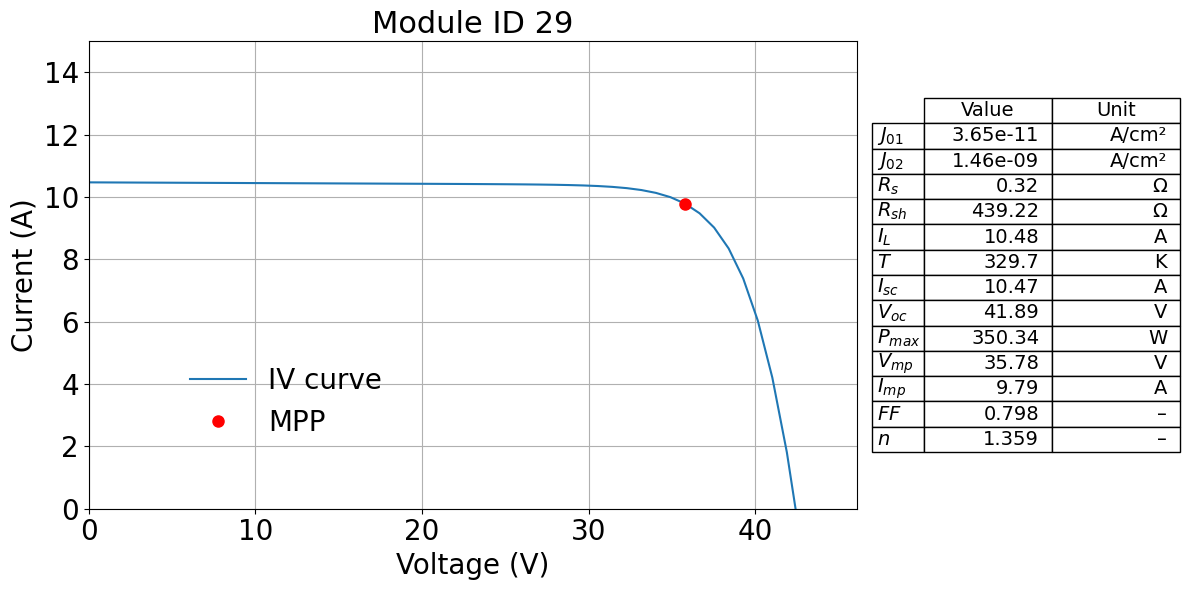

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


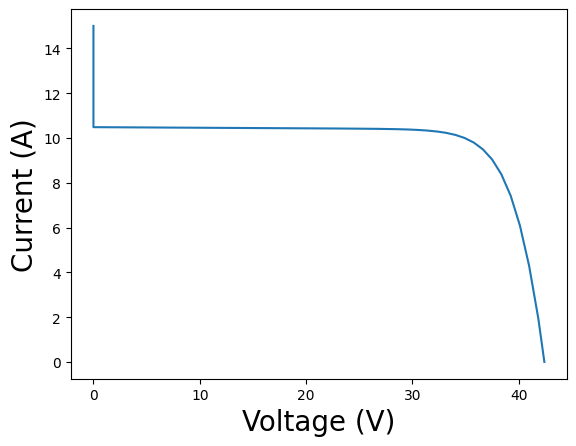

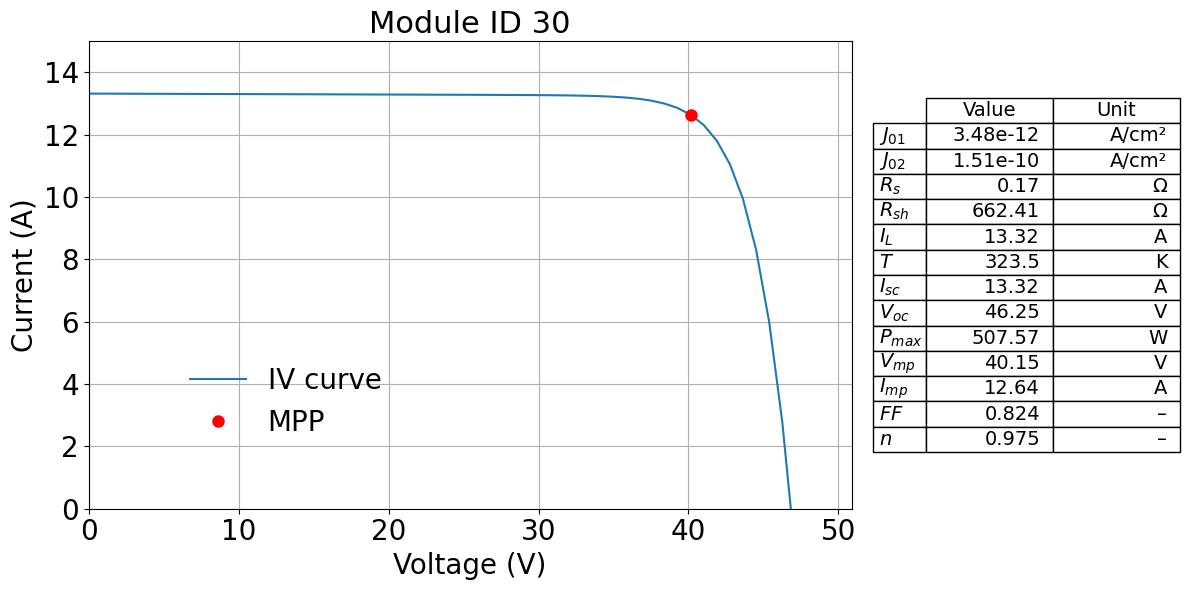

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


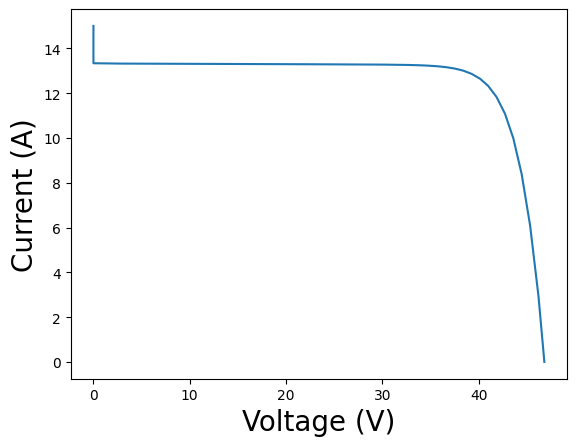

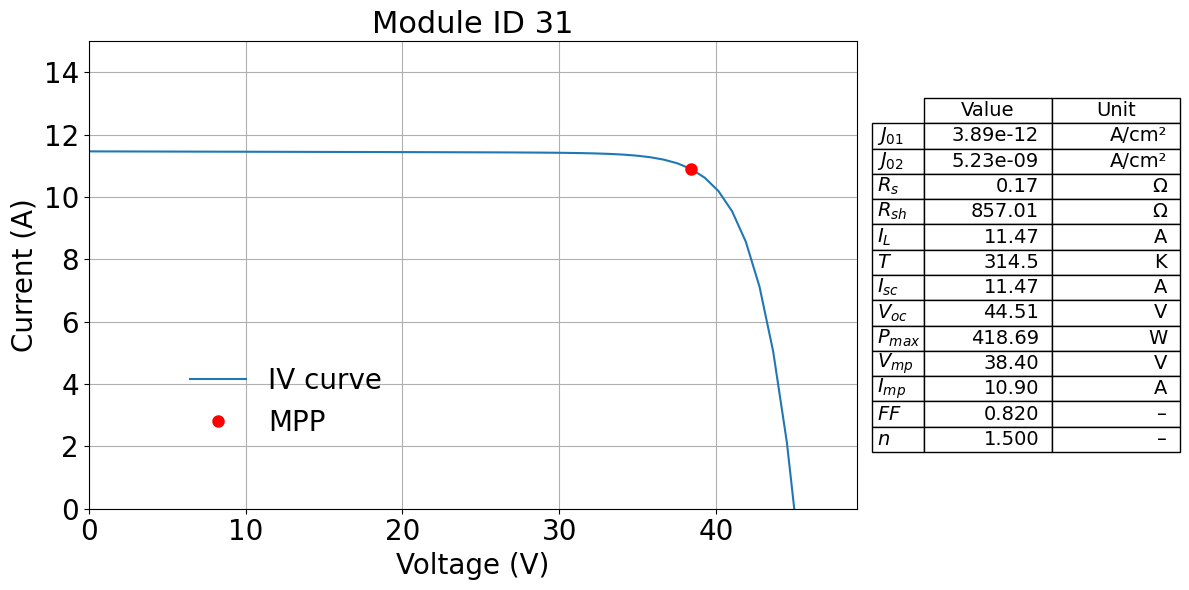

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


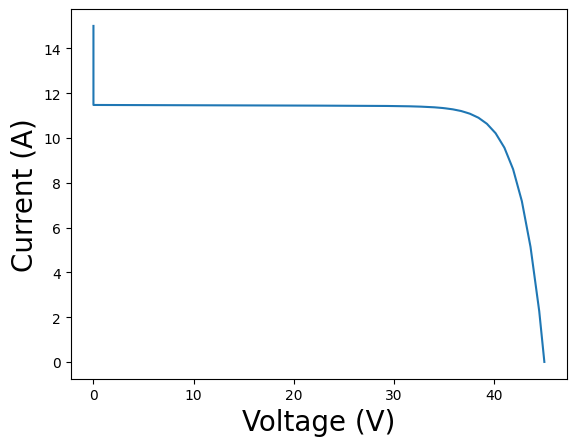

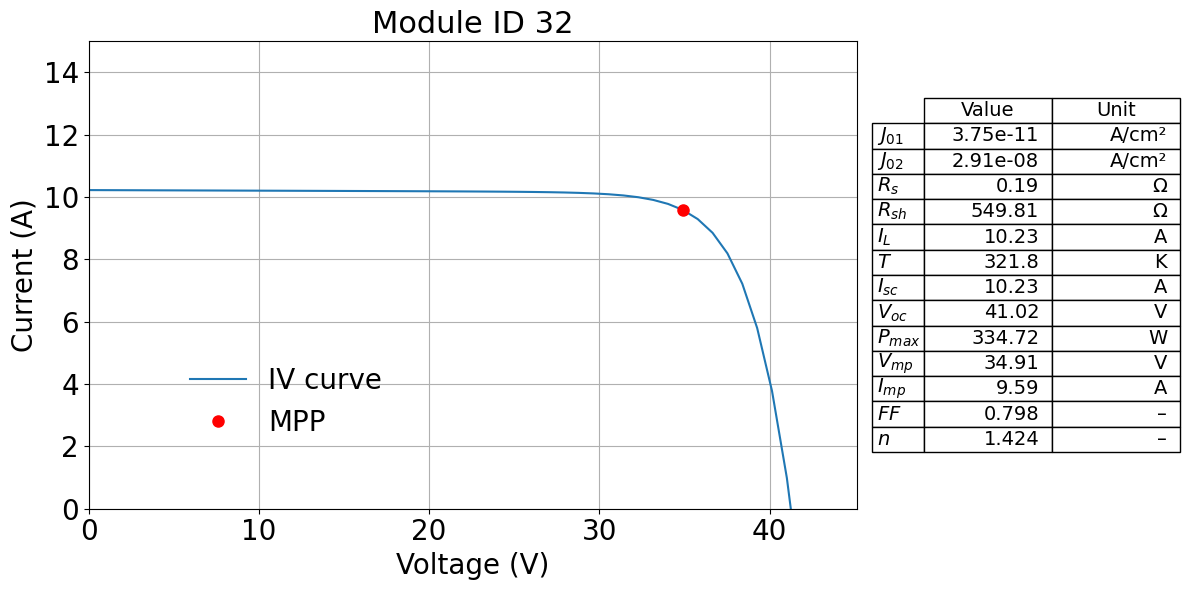

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


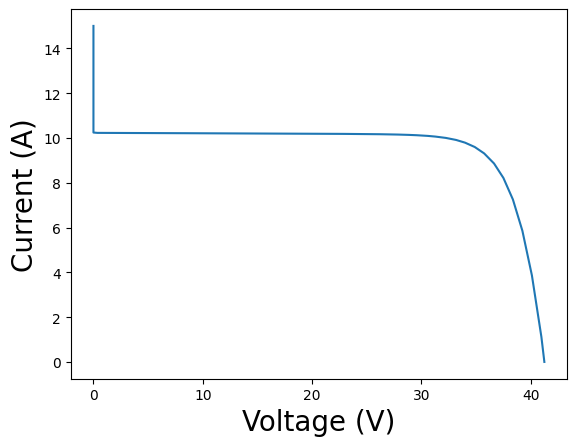

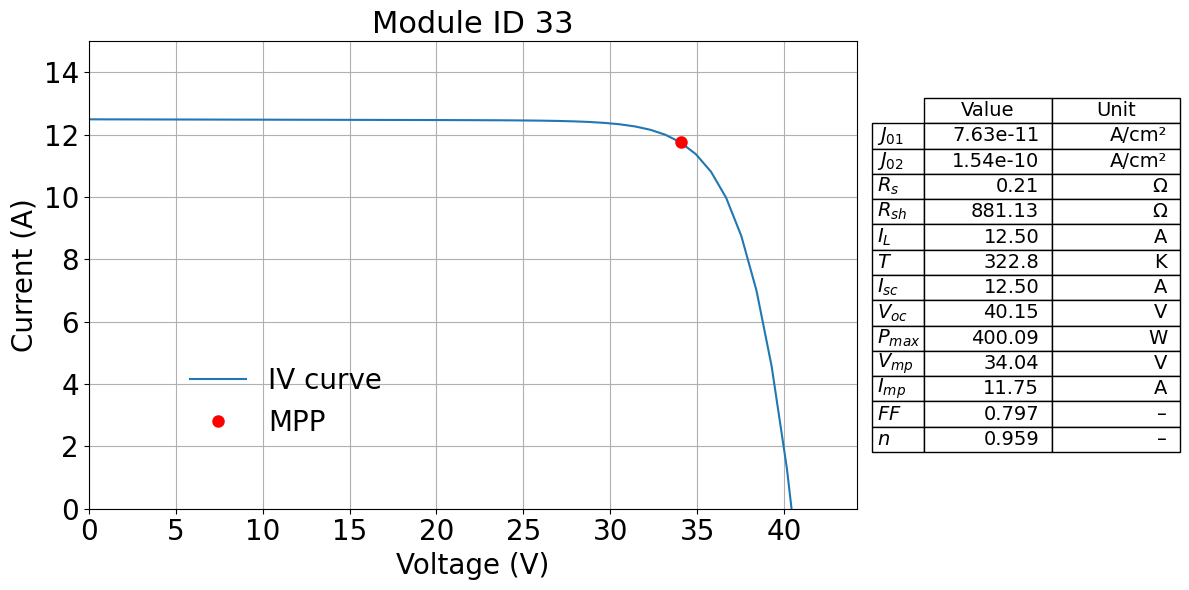

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


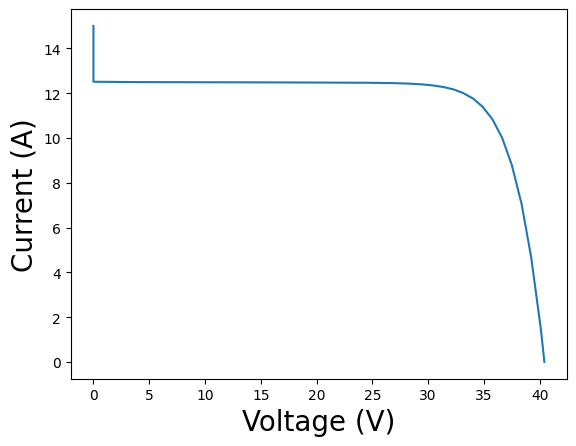

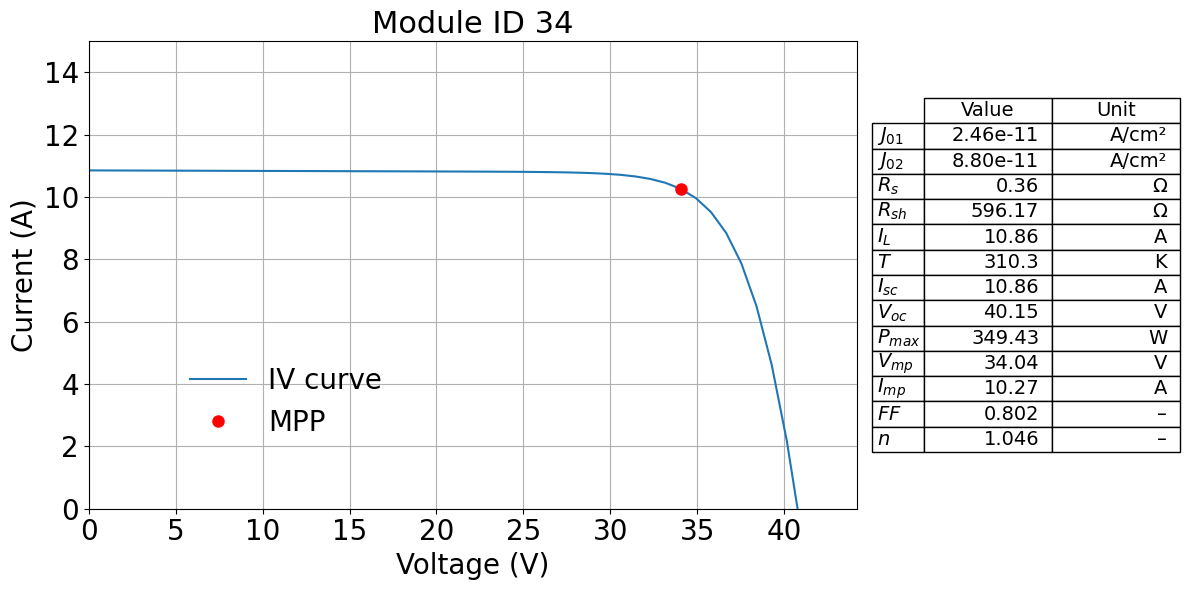

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


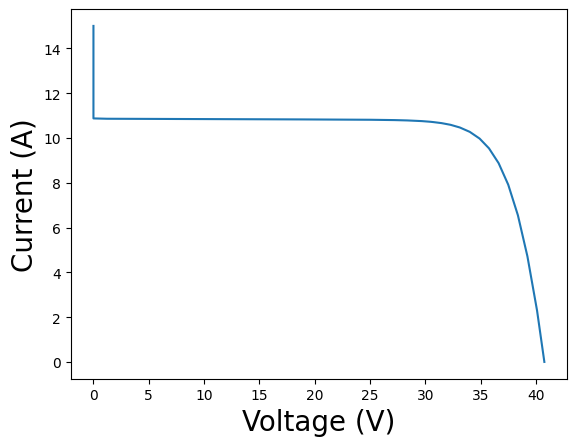

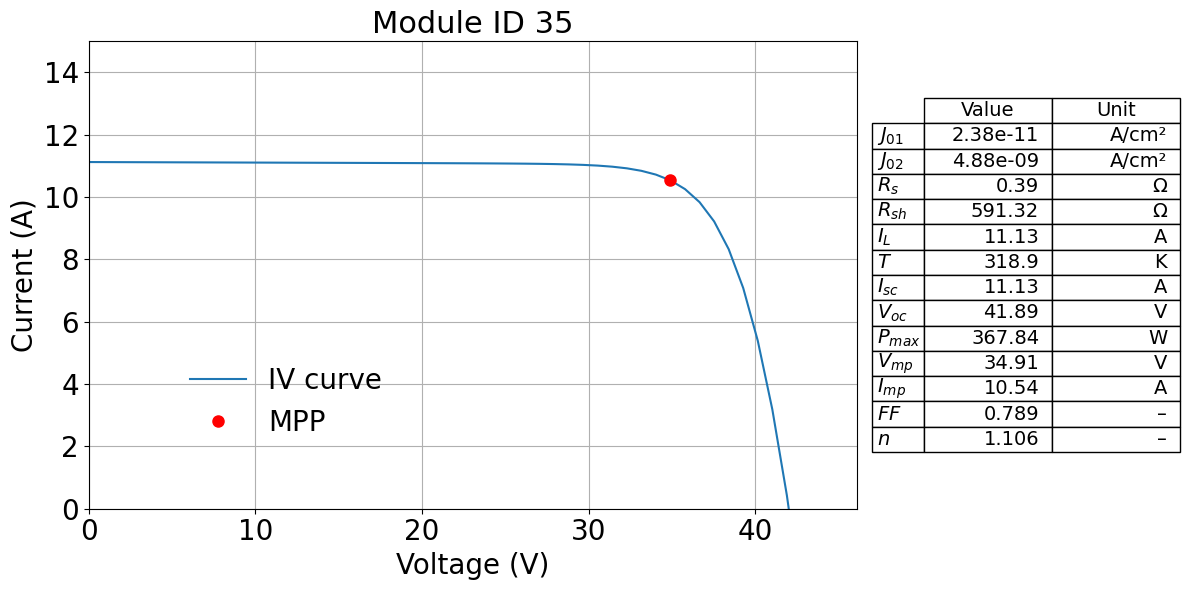

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


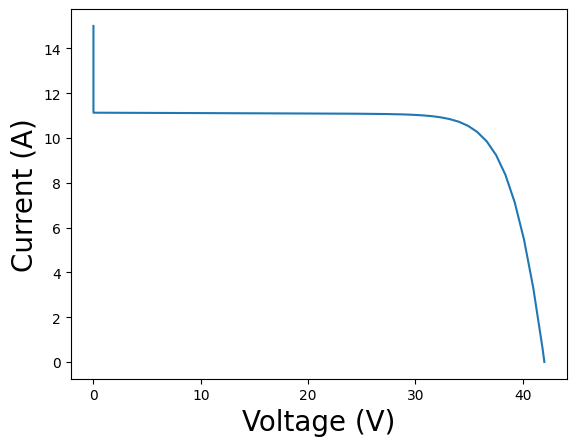

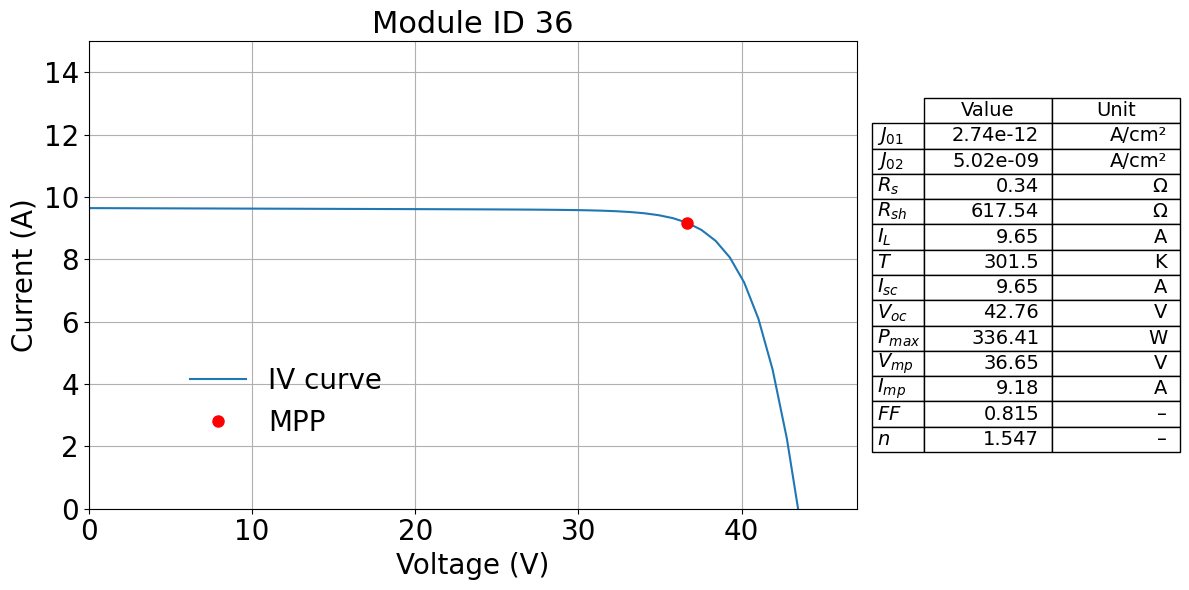

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


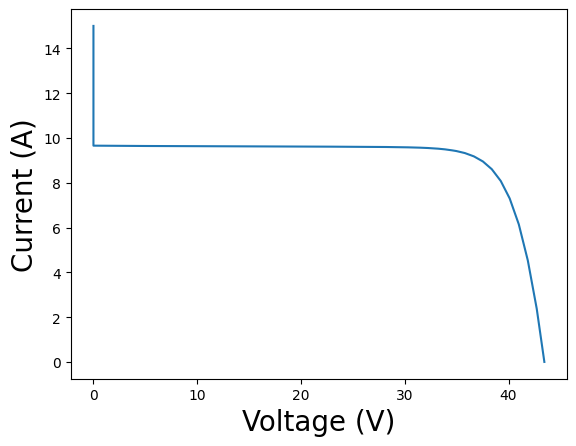

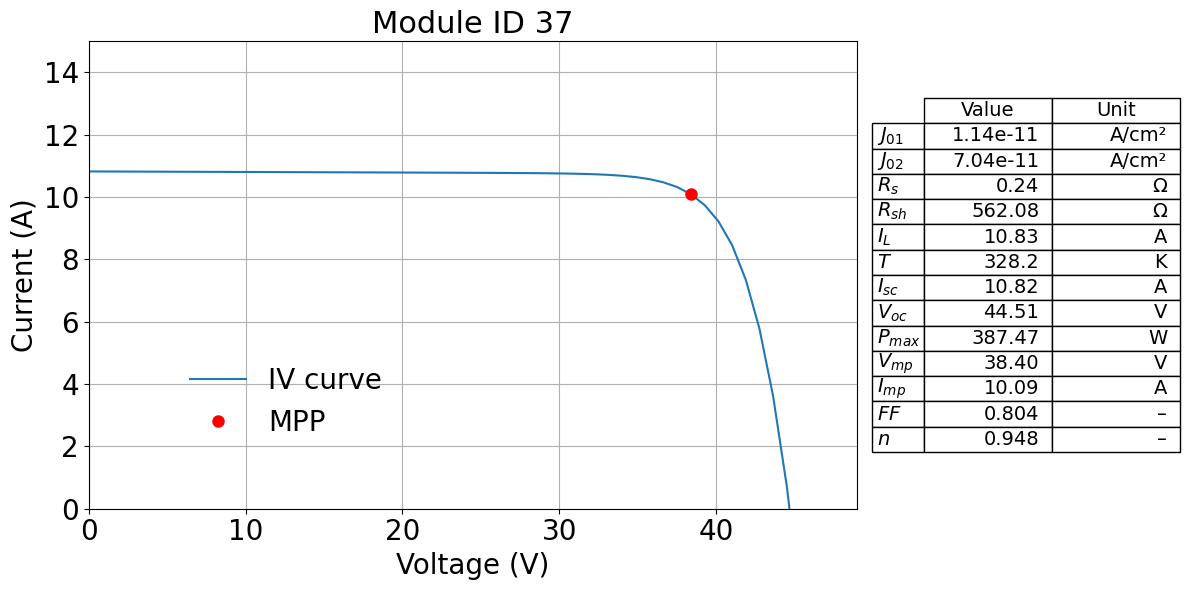

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


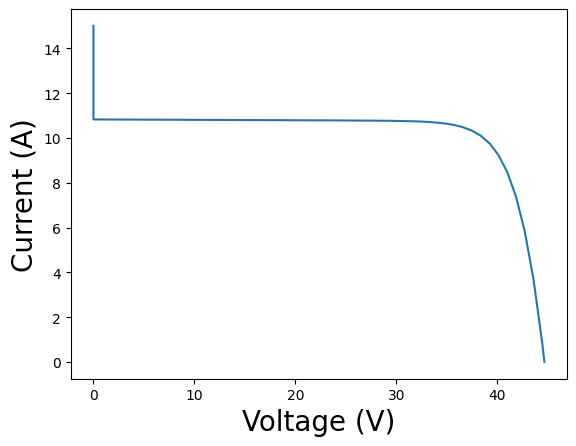

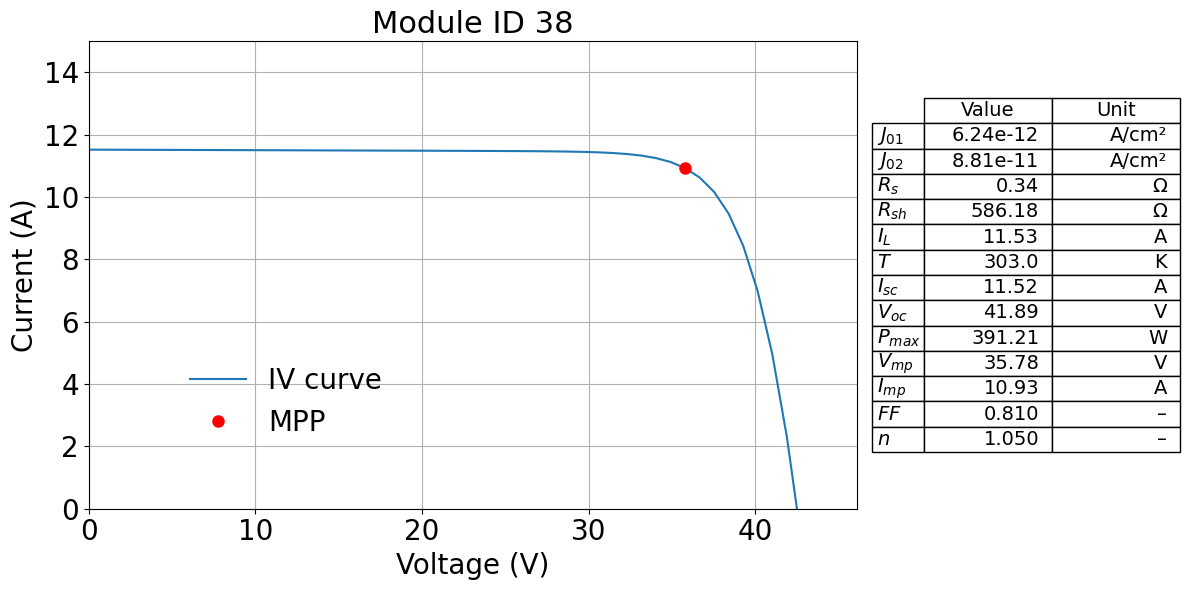

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


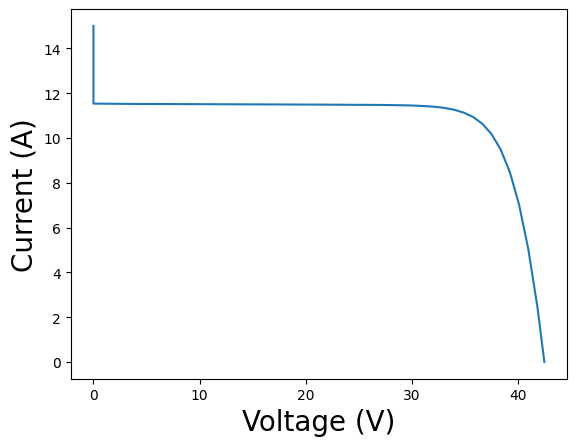

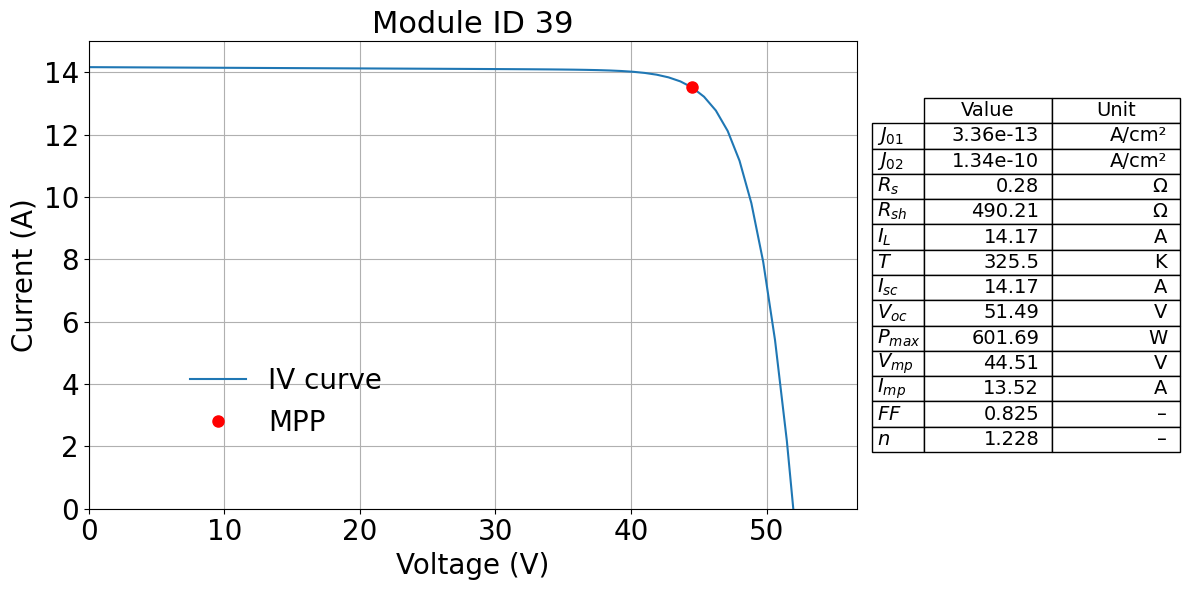

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


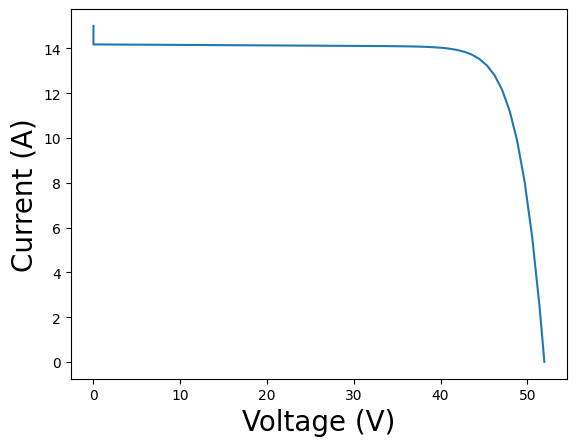

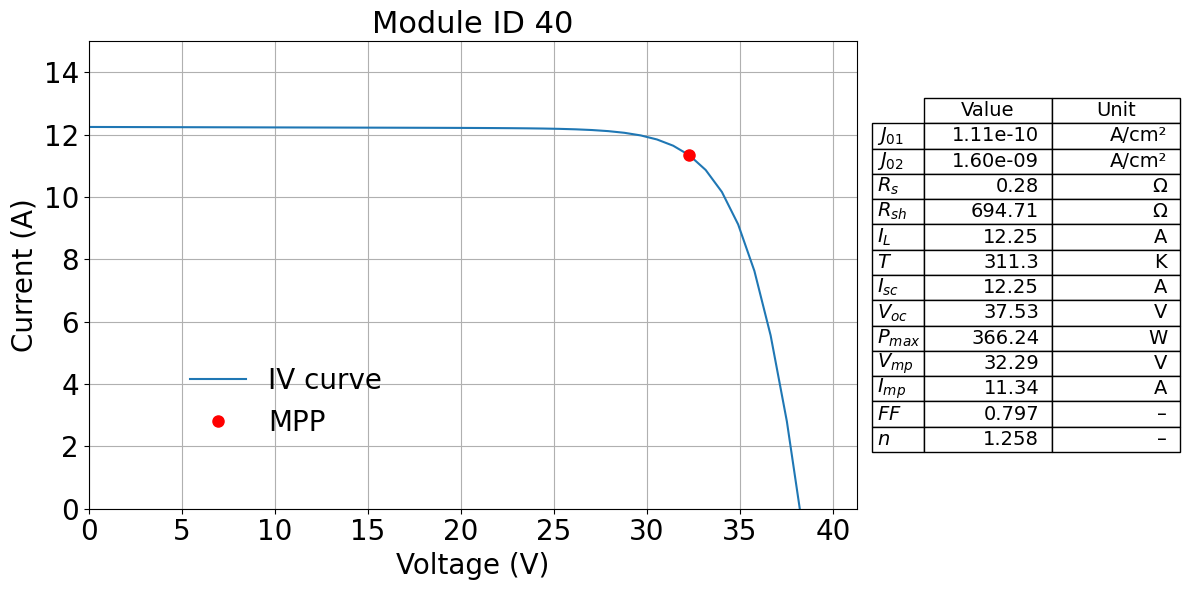

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


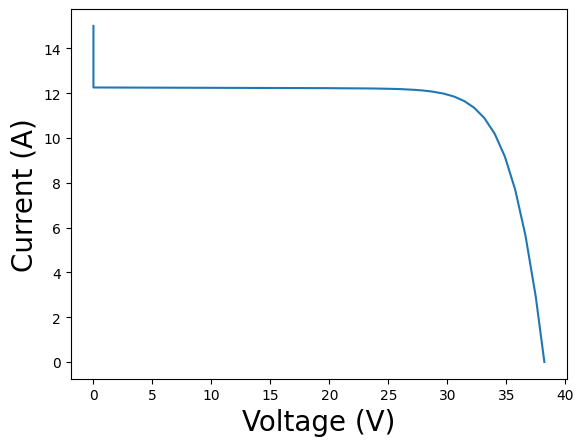

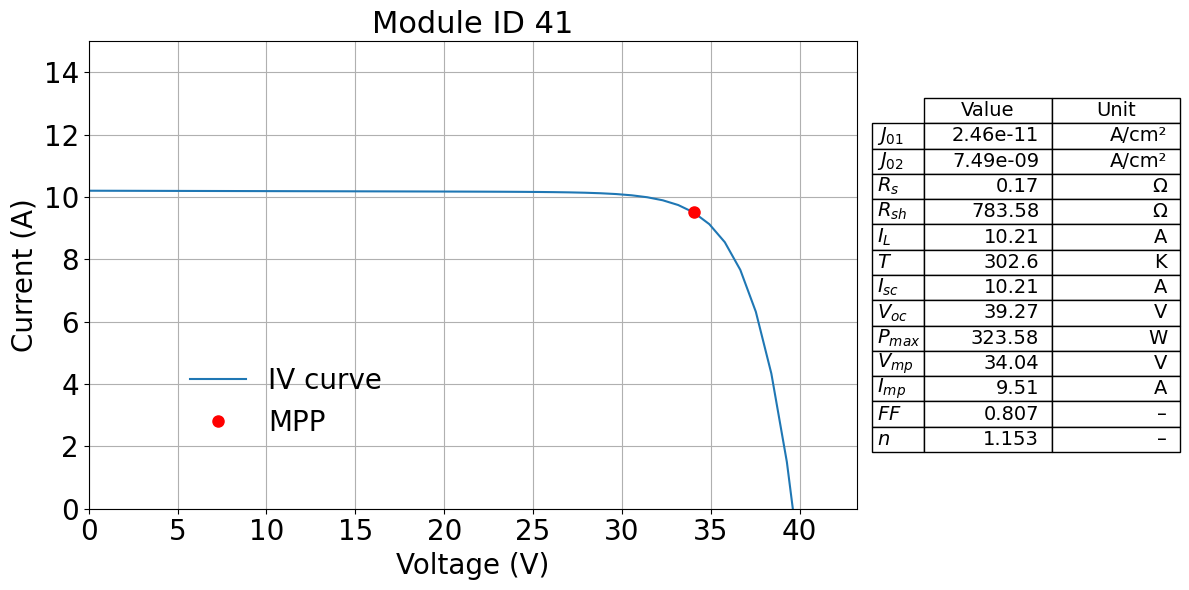

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


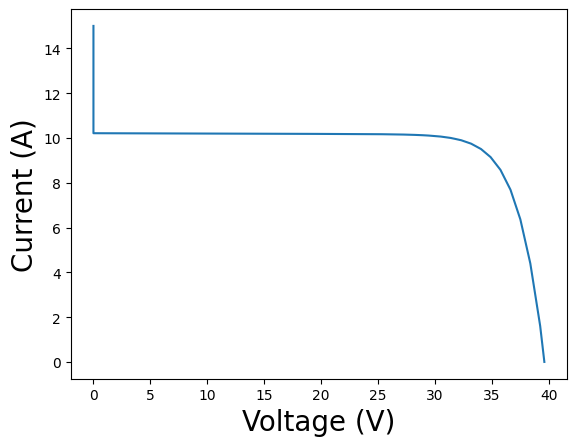

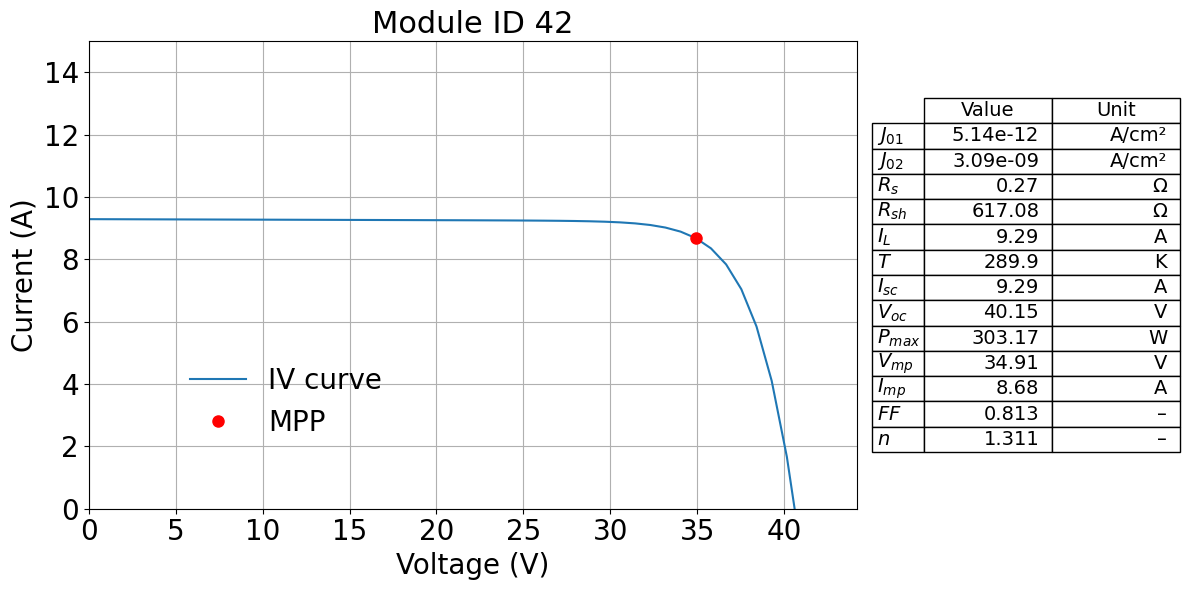

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


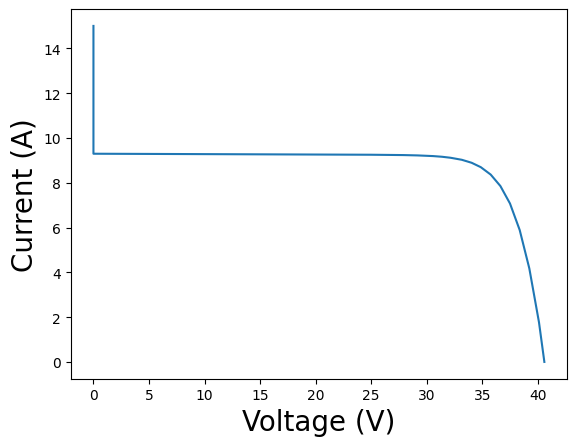

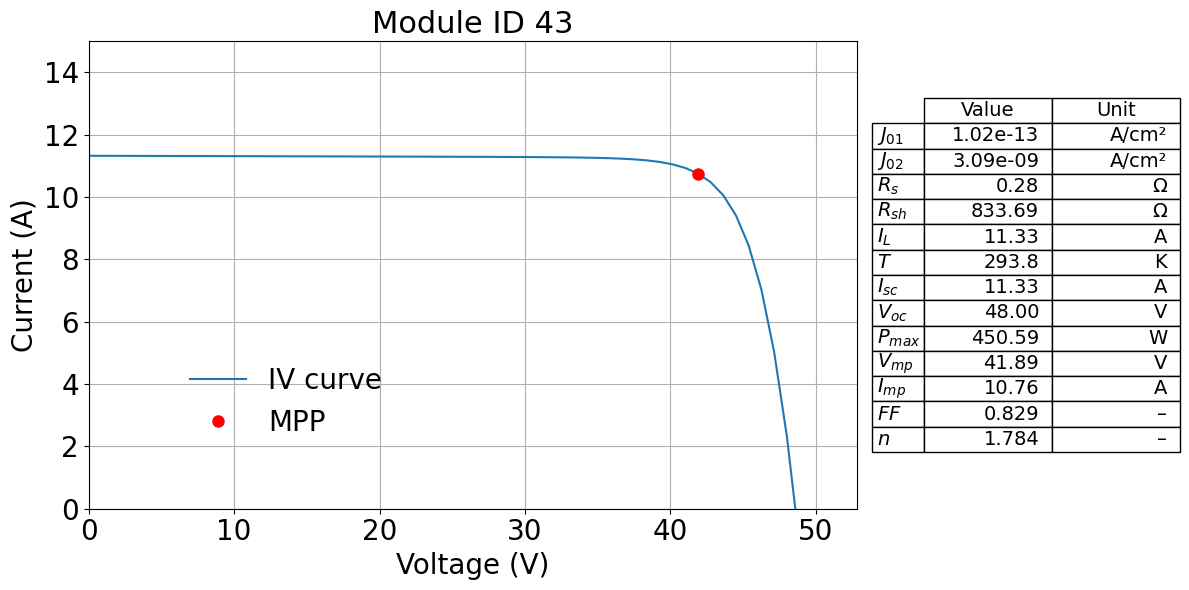

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


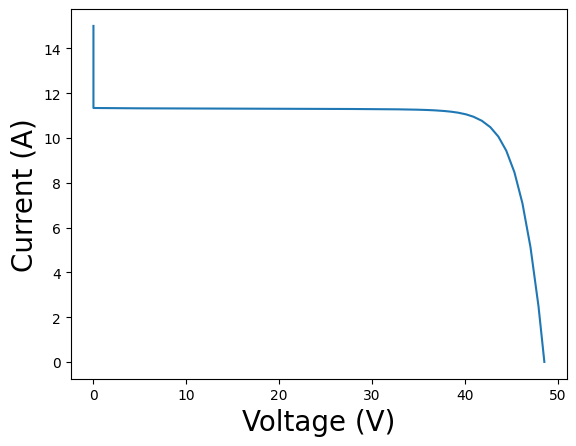

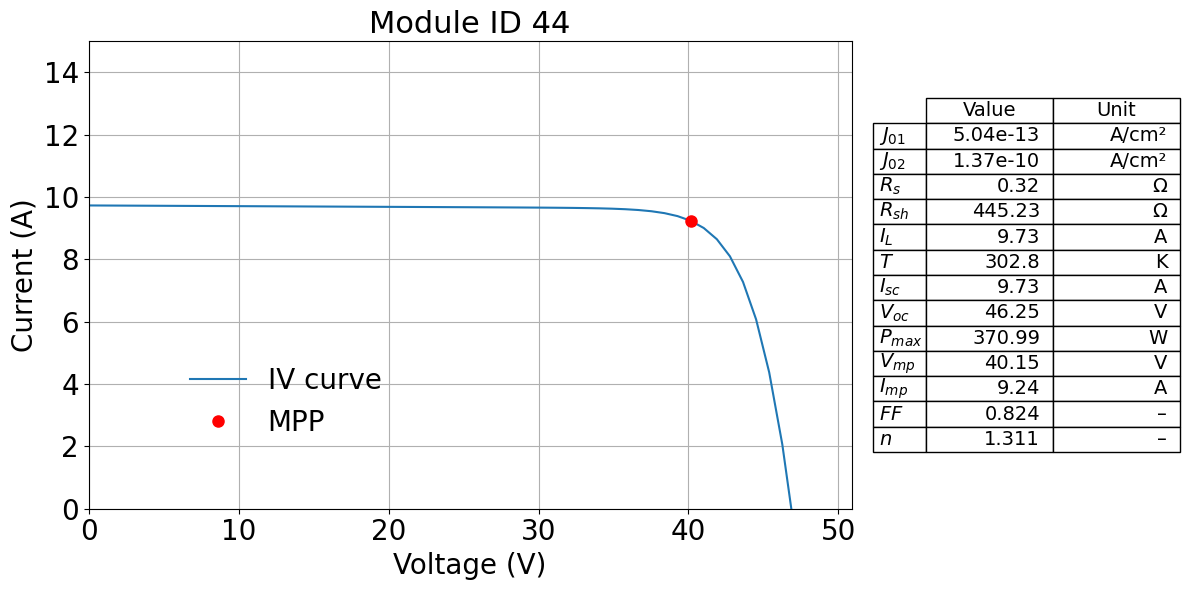

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


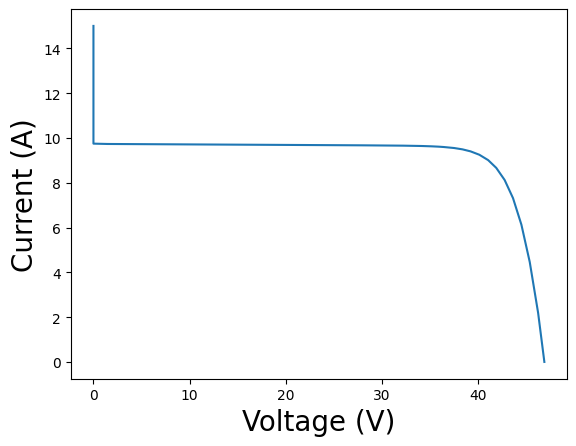

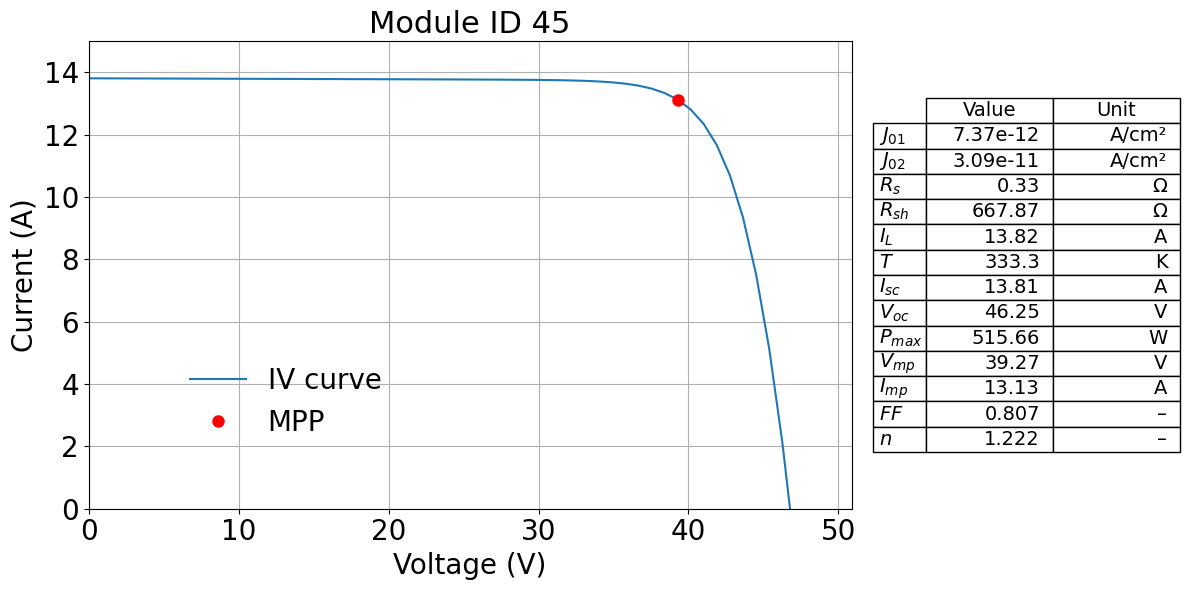

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


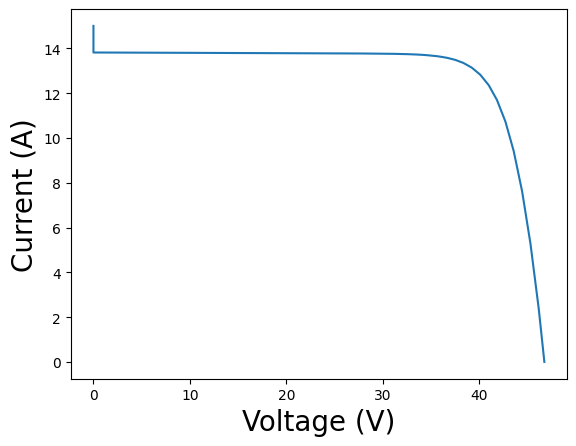

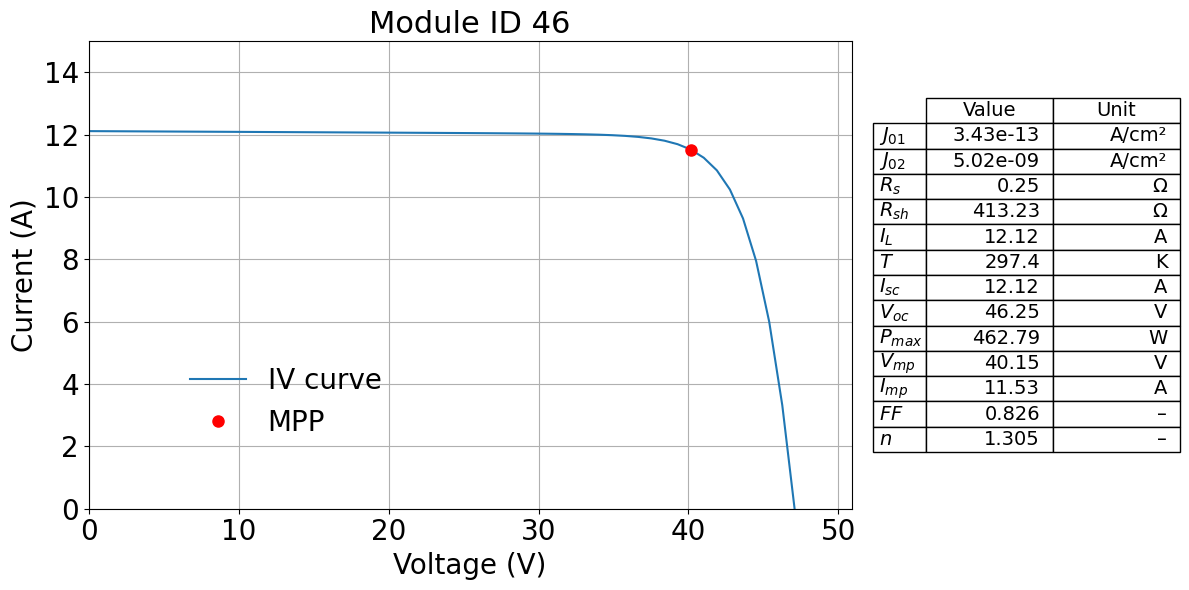

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


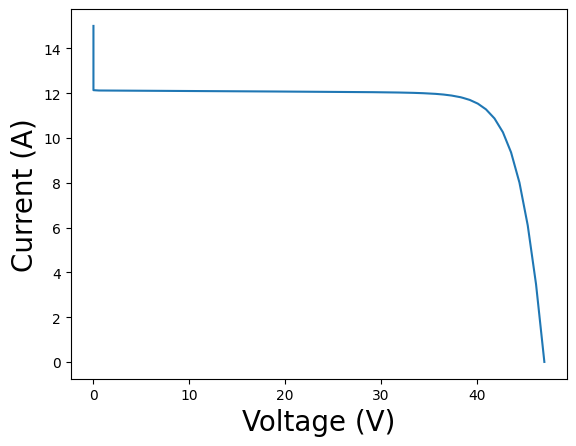

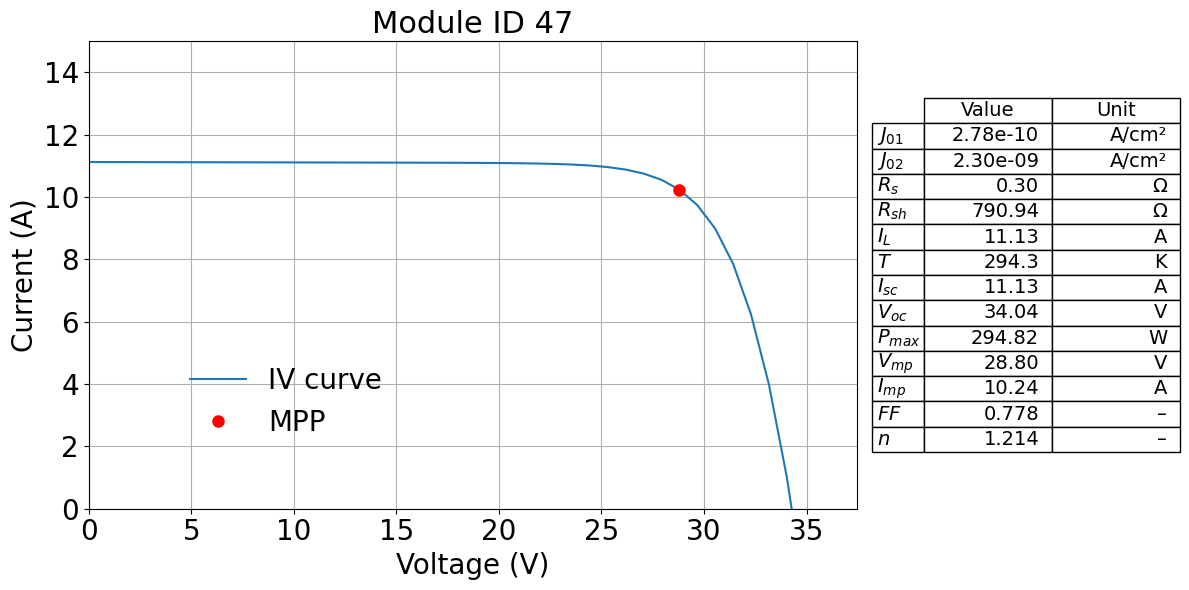

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


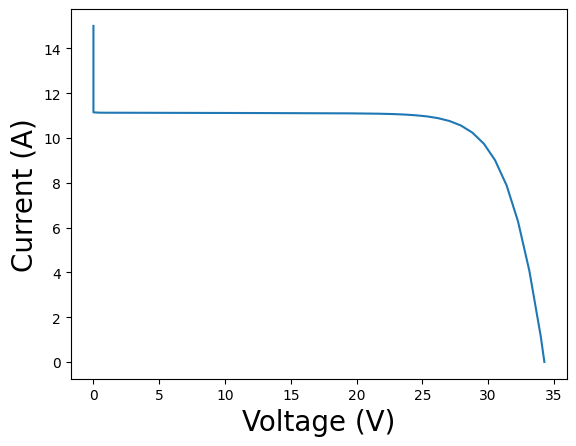

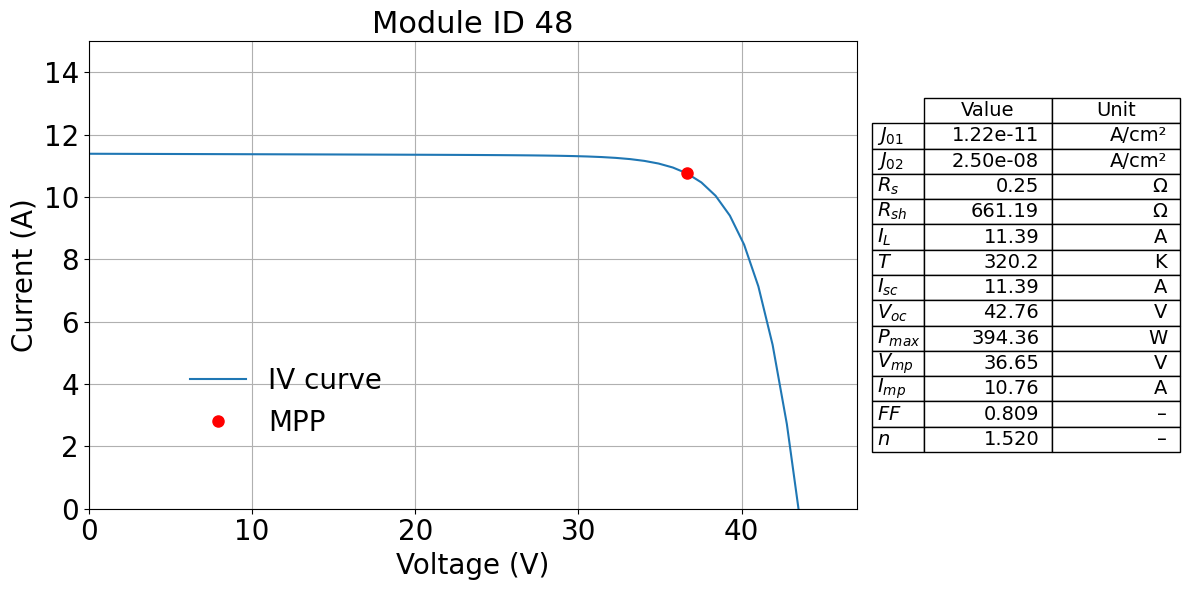

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


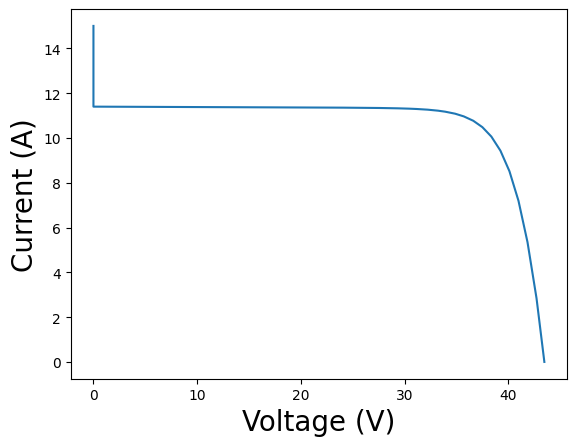

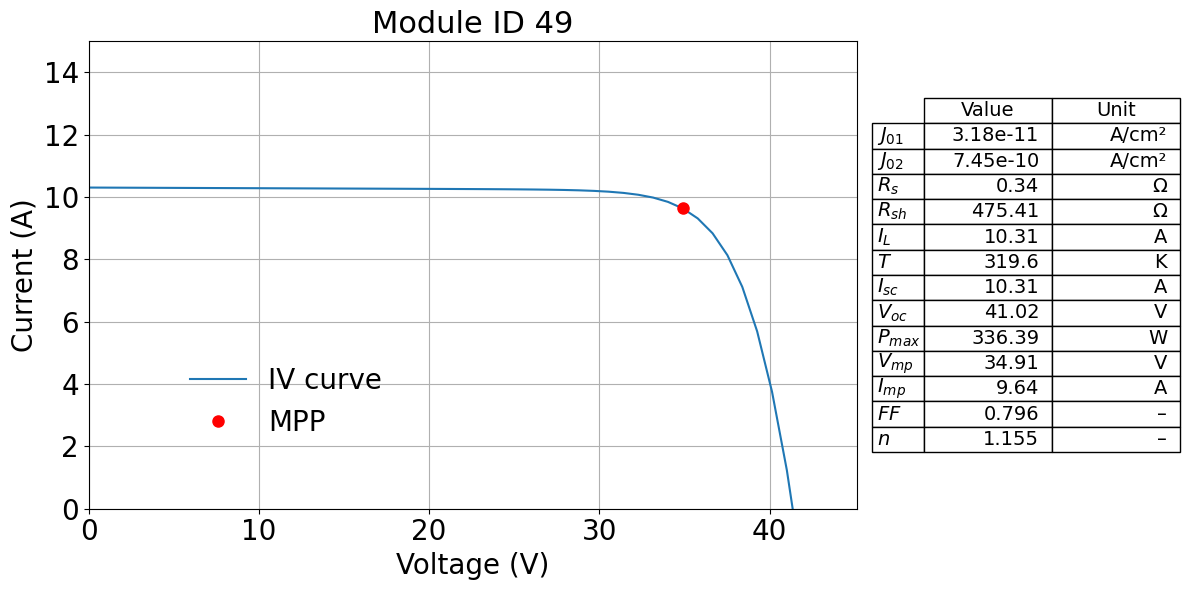

Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


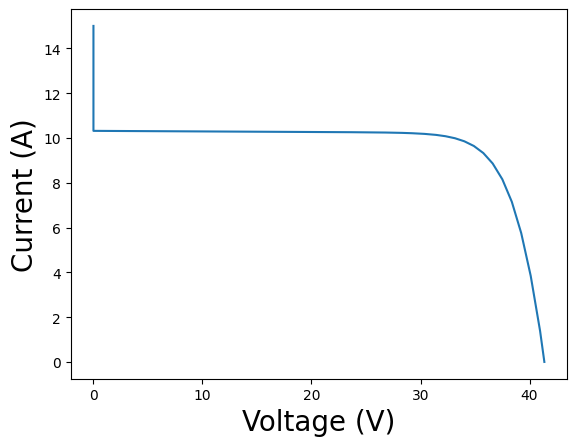

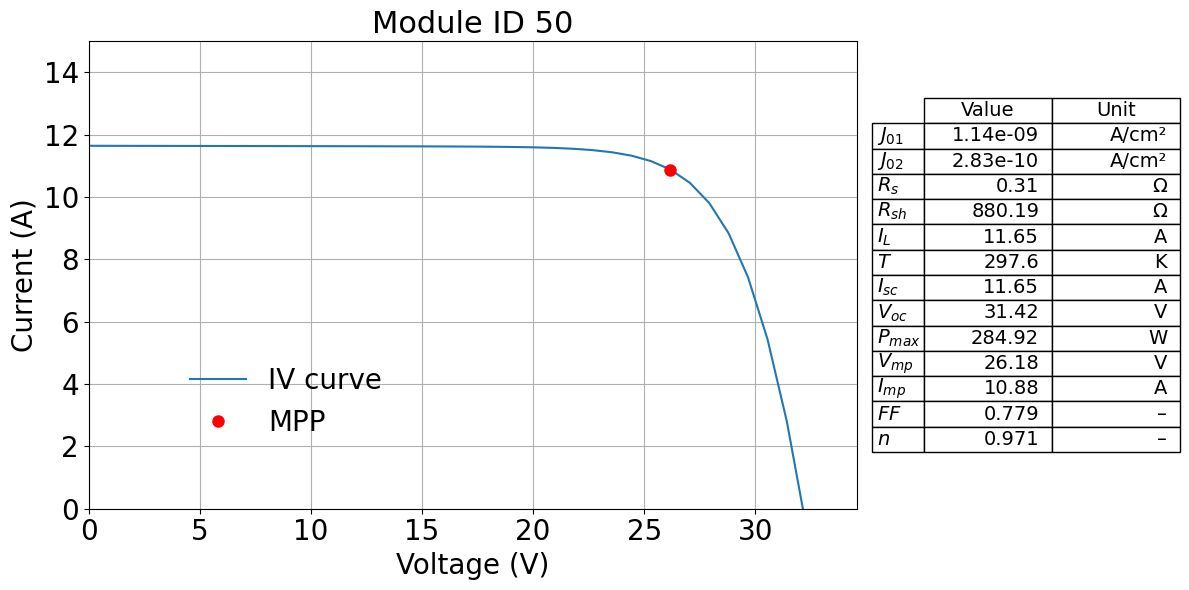

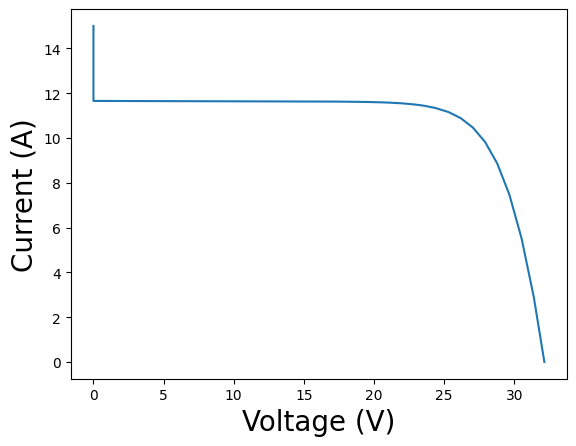

In [6]:
# %%
for index, row in df.iterrows():
    # Unpack
    Rs, Rsh = row['Rs'], row['Rsh']
    J01, J02 = row['J01'], row['J02']        # A/cm²
    IL       = row['IL']                     # A
    T        = row['T']                      # K
    module_ID = f"{index+1}"

    # Half‑cell area
    A_hcell_m2  = module_area / (num_s_cells*num_p_cells)     # m²
    A_hcell_cm2 = A_hcell_m2 * 1e4                            # cm²

    # # introduce the effect of T and IL on Rs, Rsh and n
    # # For Rs, use the temperature coefficient
    Rs = Rs * (1 + alpha_Rs * (T - 298) / 100)  # adjust Rs based on T
    # # for Rs, adjust based on G
    Rs = Rs * (1-0.217 * np.log(IL/12))  # adjust Rs based on IL, take 12 as the reference value
    # for Rsh adjust based on IL
    Rsh = Rsh + (1400-Rsh) * np.exp(-5.5*IL/12)
    # Rsh affect from T is negletable, so we don't adjust it
    # for n adjust it in the reconstructing part


    # Build 2‑diode junction
    junction = Junction(
        kind='2D', T=T,
        j01=J01, j02=J02, n1=1.0, n2=2.0,
        R_shunt = (Rsh/num_s_cells*num_p_cells)*A_hcell_cm2,
        jsc     = (IL/num_p_cells)/A_hcell_cm2,
        A       = A_hcell_cm2
    )
    opts = default_options.copy()
    opts.update({
        'internal_voltages': np.linspace(0, 0.8, 10000),
        'light_iv': True, 'T': T, 'mpp': True
    })
    iv_2diode(junction, opts)

    # build the cell object
    cell = SolarCell(
        [junction],
        R_series=Rs, R_shunt=Rsh, T=T,
        A=A_hcell_cm2,
    )
    # solve the cell IV
    # iv_multijunction(cell, opts)
    solar_cell_solver(cell, 'iv', opts)

    # extract the IV data
    V_cell, I_cell = cell.iv['IV']


    # Extract IV arrays
    V_module  = (V_cell * num_s_cells)       # V
    I_module  = (I_cell*num_p_cells)*A_hcell_cm2                  # A
    # mask  = I_module > -0.1
    # V_module = V_module[mask]
    # I_module = I_module[mask]

    # # 1) find the crossing index: where I[i] > 0 and I[i+1] < 0
    # cross_idxs = np.where((I_module[:-1] > 0) & (I_module[1:] < 0))[0]

    # if len(cross_idxs) == 0:
    #     # no crossing found: keep everything
    #     mask = np.ones_like(I_module, dtype=bool)
    # else:
    #     # take the first crossing
    #     i = cross_idxs[0]
    #     # build a mask that keeps points up through i+1
    #     mask = np.zeros_like(I_module, dtype=bool)
    #     mask[: i + 2] = True

    # # apply it
    # V_module_trim = V_module[mask]
    # I_module_trim = I_module[mask]


    # Performance metrics
    I_sc = I_module[0]
    V_oc = V_module[np.where(I_module > 0)[0][-1]]
    P    = V_module * I_module
    idx  = np.argmax(P)
    P_max= P[idx]
    V_mp = V_module[idx]
    I_mp = I_module[idx]
    FF   = P_max/(V_oc*I_sc)

    # --- Scalar n extraction (including Rsh) ---
    Vt = Boltzmann * T / e
    # Convert J0 densities from A/cm² → A/m²
    J01_SI = J01 * 1e4
    J02_SI = J02 * 1e4
    # Module-level I0 (A)
    I0_module = (J01_SI + J02_SI) * A_hcell_m2 * num_p_cells
    # I0_module = 1e-90
    # Use I_ph ≈ I_sc
    numerator = I_sc - V_oc/Rsh
    n_scalar  = V_oc / (Vt * np.log(numerator/I0_module + 1))/num_s_cells
    # introduce a +-0.2 uncertainty to n_scalar
    n_scalar = n_scalar + np.random.normal(0, 0.18)

    # Plot and table
    fig, (ax_curve, ax_table) = plt.subplots(
        1, 2,
        figsize=(figure_size[0]*2, figure_size[1]),
        gridspec_kw={'width_ratios': [3, 1]}
    )
    ax_curve.plot(V_module, I_module, label='IV curve')
    ax_curve.plot(V_mp, I_mp, 'o',
                  markeredgecolor='red', markerfacecolor='red',
                  markersize=8, label='MPP')
    ax_curve.set_xlabel('Voltage (V)', fontsize=axis_label_size)
    ax_curve.set_ylabel('Current (A)', fontsize=axis_label_size)
    ax_curve.set_title('Module ID ' + module_ID, fontsize=title_size)
    ax_curve.tick_params(labelsize=axis_num_size)
    ax_curve.grid(True)
    ax_curve.set_ylim(0, 15)
    ax_curve.set_xlim(0, V_oc*1.1)
    ax_curve.legend(fontsize=text_size, loc='lower left', bbox_to_anchor=(0.1,0.1), frameon=False)

    # Table data (now including n_scalar)
    table_data = [
        [f'{J01:.2e}',   'A/cm²'],
        [f'{J02:.2e}',   'A/cm²'],
        [f'{Rs:.2f}',    'Ω'],
        [f'{Rsh:.2f}',   'Ω'],
        [f'{IL:.2f}',    'A'],
        [f'{T:.1f}',     'K'],
        [f'{I_sc:.2f}',  'A'],
        [f'{V_oc:.2f}',  'V'],
        [f'{P_max:.2f}', 'W'],
        [f'{V_mp:.2f}',  'V'],
        [f'{I_mp:.2f}',  'A'],
        [f'{FF:.3f}',    '–'],
        [f'{n_scalar:.3f}','–']
    ]
    row_labels = [
        r'$J_{01}$', r'$J_{02}$', r'$R_{s}$',  r'$R_{sh}$',
        r'$I_{L}$',  r'$T$',      r'$I_{sc}$', r'$V_{oc}$',
        r'$P_{max}$',r'$V_{mp}$', r'$I_{mp}$', r'$FF$',
        r'$n$'
    ]
    col_labels = ['Value','Unit']

    ax_table.axis('off')
    tbl = ax_table.table(
        cellText=table_data,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc='center'
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(14)
    tbl.scale(1, 1.5)

    plt.tight_layout()

    # Save to timestamped folder
    timestamp    = datetime.now().strftime("%Y%m%d_%H%M%S")
    curve_folder = os.path.join(save_folder, timestamp)
    os.makedirs(curve_folder, exist_ok=True)

    fig.savefig(os.path.join(curve_folder, "IV_curve.png"), dpi=300, bbox_inches='tight')
    plt.show()

    pd.DataFrame(table_data, columns=col_labels, index=row_labels).to_csv(
        os.path.join(curve_folder, "IV_curve_table.csv"),
        index=True, header=True
    )

    # get the IV data ready for saving, because we will do everything based on current, interpolate based on the current results
    I_modules_export = np.linspace(0, 15, 1000)
    # sort the I_module and V_module arrays together by puttin them as a table
    # and sort the table by the first column (I_module)
    # then extract the sorted columns
    IV_module = np.array([I_module, V_module]).T
    IV_module = IV_module[np.argsort(IV_module[:, 0])]
    V_modules_export = np.interp(I_modules_export, IV_module[:, 0], IV_module[:, 1])
    # V_2_diode_plotting = np.interp(I_2_diode_plotting, iv_curve_df['I'], iv_curve_df['V'])
    # visualise the interpolation
    # plt.plot(V_module, I_module, 'o', label='Original')
    plt.plot(V_modules_export, I_modules_export, label='Interpolated')
    plt.xlabel('Voltage (V)', fontsize=axis_label_size)
    plt.ylabel('Current (A)', fontsize=axis_label_size)
    # plt.ylim(0, 15)


    pd.DataFrame({'V': V_modules_export, 'I': I_modules_export}).to_csv(
        os.path.join(curve_folder, "IV_curve_data.csv"),
        index=False
    )